# Self-supervised model

* Complexity of the Task:

Weather forecasting, especially on a global scale, is inherently complex. Self-supervised learning can be advantageous here because it can help the model learn to understand and represent complex patterns in the data, even without explicit labels.

* Data Characteristics:

Time series data, like weather data, often contains inherent patterns and structures (seasonality, trends, etc.). Self-supervised learning can be particularly effective in extracting and leveraging these patterns to improve the model’s understanding of the underlying processes.

* Robustness and Generalization:

Self-supervised learning can potentially lead to more robust models that generalize better to unseen data. This is crucial for global weather forecasting, where the model needs to perform well across a wide range of geographic and climatic conditions.

In [1]:
import sys
sys.path.append("./PatchTST_self_supervised/")
from types import SimpleNamespace
import xarray as xr
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np


import matplotlib.pyplot as plt

from PatchTST_self_supervised.src.models.patchTST import PatchTST
from PatchTST_self_supervised.src.learner import Learner, transfer_weights
from PatchTST_self_supervised.src.callback.tracking import *
from PatchTST_self_supervised.src.callback.patch_mask import *
from PatchTST_self_supervised.src.callback.transforms import *
from PatchTST_self_supervised.src.metrics import *
from PatchTST_self_supervised.src.basics import set_device
from PatchTST_self_supervised.datautils import *

from src.data.datamodule import DataLoaders


In [2]:
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 1e-4,
    
    'batch_size':64, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 50, # number of pre-training epochs
    'pretrained_model_id': 2, # id of the saved pretrained model
    
}

config_obj = SimpleNamespace(**config)

## Dataset and Dataloader

In [3]:
PATH = "./"

ds_full = xr.open_zarr("s3://wfp-ops-userdata/public-share/ndvi_world.zarr")

new_time_chunk_size = -1
new_latitude_chunk_size = 50
new_longitude_chunk_size = 50
target_chunks = {'time':
                 new_time_chunk_size, 'latitude': new_latitude_chunk_size, 'longitude': new_longitude_chunk_size}

max_mem = "12GB"

time_step_size = 30  # Define batch size
num_batches = ds_full.dims['time'] // time_step_size


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'NDVI Rechunked/ndvi_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

NDVI = xr.concat(concatenated_ds_list, dim='time')


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'RFH Rechunked/rfh_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

# Concatenate all datasets along the time dimension
RFH = xr.concat(concatenated_ds_list, dim='time')


In [4]:
NDVI_lta = NDVI.sel(time=slice("2003-02-01","2018-12-31"))
NDVI_lta  = NDVI_lta .groupby(NDVI_lta.time.dt.strftime("%m-%d")).mean()
NDVI_lta = NDVI_lta.sel(strftime=NDVI.time.dt.strftime("%m-%d"))

RFH_lta = RFH.sel(time=slice("2003-02-01","2018-12-31"))
RFH_lta  = RFH_lta .groupby(RFH_lta.time.dt.strftime("%m-%d")).mean()
RFH_lta = RFH_lta.sel(strftime=RFH.time.dt.strftime("%m-%d"))

In [5]:
def get_LTA (lat,lon,index, seq_len, pred_len):
    
    s_begin = index
    s_end = s_begin + seq_len
    r_begin = s_end 
    r_end = r_begin + pred_len
        

    ndvi_lta_prediction = NDVI_lta.isel(time=slice(r_begin,r_end), latitude=lat, longitude=lon).band.values
#     rfh_lta_prediction = RFH_lta.isel(time=slice(r_begin,r_end), latitude=lat, longitude=lon).band.values
    
    return ndvi_lta_prediction
 

5 min to load one time serie

In [7]:
def get_model(config, headtype='pretrain'):
    stride  = config.stride    
    # get number of patches
    num_patch = (max(config.sequence_length, config.patch_len)-config.patch_len) // stride + 1    
    print('number of patches:', num_patch)
    
    # get model
    model = PatchTST(c_in=config.c_in,
                target_dim=config.prediction_length,
                patch_len=config.patch_len,
                stride=stride,
                num_patch=num_patch,
                n_layers=4, #number of Transformer layers
                n_heads=16,#number of Transformer heads
                d_model=128, #Transformer d_model
                shared_embedding=True,
                d_ff=512, #Tranformer MLP dimension                       
                dropout=2e-1, #Transformer dropout
                head_dropout=2e-1, #head dropout
                act='relu',
                head_type=headtype,
                res_attention=False
                )        
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model



In [46]:
model = get_model(config_obj,'pretrain')

number of patches: 7
number of model params 795397


In [ ]:
def find_lr(config_obj):
    # get dataloader
    dls = get_dls(config_obj, Rain_Ndvi_Dataset)
    model = get_model(config_obj)
    # get loss
    loss_func = torch.nn.MSELoss(reduction='mean')
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=False)] if config_obj.revin else []
    cbs += [PatchMaskCB(patch_len=config_obj.patch_len, stride=config_obj.stride, mask_ratio=config_obj.mask_ratio)]
        
    # define learner
    learn = Learner(dls, model, 
                        loss_func, 
                        lr=config_obj.lr, 
                        cbs=cbs,
                        )                        
    # fit the data to the model
    suggested_lr = learn.lr_finder()
    print('suggested_lr', suggested_lr)
    return suggested_lr

find_lr(config_obj)

This method typically involves training the model for a few epochs with a range of learning rates and recording the loss at each step. The learning rate that gives the fastest decrease in loss is considered optimal or near-optimal for the training process.

In [80]:
def pretrain_func(save_pretrained_model, save_path, lr=config_obj.lr):
    
     
    if not os.path.exists(save_path): os.makedirs(save_path)
    
    print(save_path)

    # get dataloader
    dls = get_dls(config_obj, Rain_Ndvi_Dataset)
    # get model
    model = get_model(config_obj)
    # get loss
    loss_func = torch.nn.MSELoss(reduction='mean')
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=False)] if config_obj.revin else []
    cbs += [
         PatchMaskCB(patch_len=config_obj.patch_len, stride=config_obj.stride, mask_ratio=config_obj.mask_ratio),
         SaveModelCB(monitor='valid_loss', fname=save_pretrained_model,                       
                        path=save_path)
        ]
    # define learner
    learn = Learner(dls, model, 
                        loss_func, 
                        lr=lr, 
                        cbs=cbs,
                        #metrics=[mse]
                        )                        
    # fit the data to the model
    learn.fit_one_cycle(n_epochs=config_obj.n_epochs_pretrain, lr_max=lr)

    train_loss = learn.recorder['train_loss']
    valid_loss = learn.recorder['valid_loss']
    df = pd.DataFrame(data={'train_loss': train_loss, 'valid_loss': valid_loss})
    df.to_csv(save_path + save_pretrained_model + '_losses.csv', float_format='%.6f', index=False)


In [ ]:
save_pretrained_model = 'patchtst_pretrained_cw'+str(config_obj.sequence_length)+'_patch'+str(config_obj.patch_len) + '_stride'+str(config_obj.stride) + '_epochs-pretrain' + str(config_obj.n_epochs_pretrain) + '_mask' + str(config_obj.mask_ratio) + '_model' + str(config_obj.pretrained_model_id)
save_path = 'saved_models' + '/masked_patchtst/'
pretrain_func(save_pretrained_model, save_path)

saved_models/masked_patchtst/
Reselecting the pixel non NaN
Reselecting the pixel non NaN
Reselecting the pixel non NaN
Reselecting the pixel non NaN


In [20]:
pretrained_model_name= save_path + save_pretrained_model+".pth"

In [21]:
model = transfer_weights(pretrained_model_name, model)

weights from saved_models/masked_patchtst/patchtst_pretrained_cw36_patch5_stride5_epochs-pretrain50_mask0.4_model2.pth successfully transferred!



**Regularization**

Improved Performance on Validation Data: Since all neurons are active during validation, the network can leverage its full capacity, which might result in better performance (lower loss) compared to the training phase where dropout is active.

Generalization Capability: By disabling dropout during validation, you get a clearer picture of how well the network can generalize to unseen data without the noise introduced by dropout.

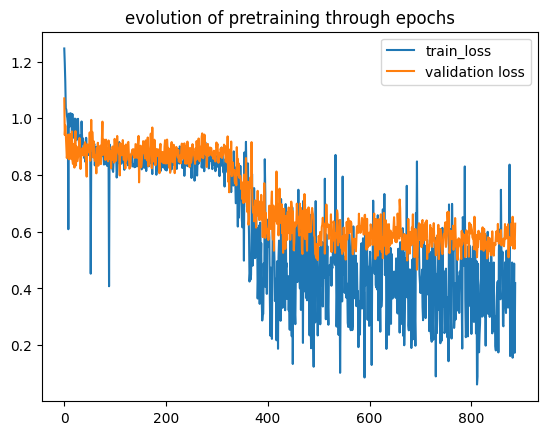

In [154]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = 'saved_models/masked_patchtst/patchtst_pretrained_cw36_patch5_stride5_epochs-pretrain1000_mask0.4_model4_losses.csv'

df = pd.read_csv(file_path)

plt.plot(df['train_loss'], label="train_loss")
plt.plot(df['valid_loss'], label="validation loss")
plt.legend()
plt.title("evolution of pretraining through epochs")

plt.show()


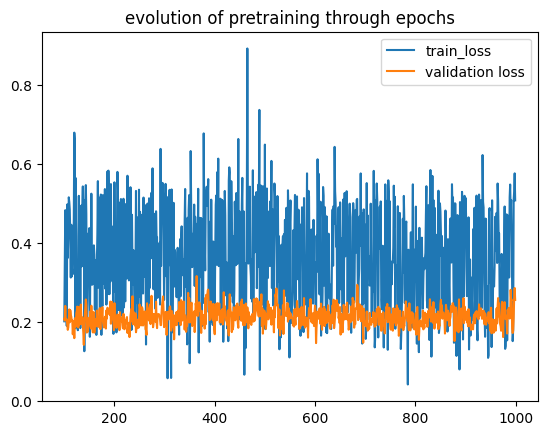

In [24]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = 'saved_models/masked_patchtst/patchtst_pretrained_cw36_patch5_stride5_epochs-pretrain1000_mask0.4_model4_losses.csv'

df = pd.read_csv(file_path)

plt.plot(df['train_loss'][100:], label="train_loss")
plt.plot(df['valid_loss'][100:], label="validation loss")
plt.legend()
plt.title("evolution of pretraining through epochs")

plt.show()


# Finetune

In [6]:
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 3e-4,
    
    'batch_size':128, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 200, # number of pre-training epochs
    'n_epochs_finetune' : 50, # number of pre-training epochs
    'pretrained_model_id': 1, # id of the saved pretrained model
    
    
    'save_finetuned_model': './finetuned_d128',
    
    'save_path' :  'saved_models' + '/masked_patchtst/'
    
}

config_obj = SimpleNamespace(**config)

In [7]:
class Rain_Ndvi_Dataset(Dataset):
    def __init__(self, ndvi_xarray, rfh_xarray, size=None, split='train', scale=True):
        if size is None:
            self.seq_len = 30
            self.label_len = 10
            self.pred_len = 10
        else:
            self.seq_len, self.label_len, self.pred_len = size

        assert split in ['train', 'val', 'test']
        self.split = split
        self.scale = scale
        self.ndvi_xarray = ndvi_xarray
        self.rfh_xarray = rfh_xarray
        self.features = ['rfh', 'ndvi']

        self.initialize_data_for_epoch()

    def initialize_data_for_epoch(self):
        # Randomly select a pixel
        lat, lon = self.select_random_pixel()
        
        while np.isnan(self.ndvi_xarray.isel(latitude=lat, longitude=lon, time=0).band.values) or np.isnan(self.rfh_xarray.isel(latitude=lat, longitude=lon, time=0).band.values):
            lat, lon = self.select_random_pixel()
        # Generate DataFrame for the selected pixel
        if self.split == "test":
            print("(lat, lon) selected for test:",  (lat, lon))
            
        self.dataframe = self.generate_pixel_dataframe(lat, lon)
        # Read and split data
        self.__read_data__()

    def select_random_pixel(self):
        lat = np.random.randint(0, self.rfh_xarray.latitude.shape[0])
        lon = np.random.randint(0, self.rfh_xarray.longitude.shape[0])
        return lat, lon

    def generate_pixel_dataframe(self, lat, lon):
        ndvi = self.ndvi_xarray.isel(latitude=lat, longitude=lon).to_dataframe().reset_index()[['time', 'band']]
        ndvi.rename(columns={'band': 'ndvi'}, inplace=True)
        ndvi.set_index('time', inplace=True)

        rfh = self.rfh_xarray.isel(latitude=lat, longitude=lon).to_dataframe().reset_index()[['time', 'band']]
        rfh.rename(columns={'band': 'rfh'}, inplace=True)
        rfh.set_index('time', inplace=True)
        df = pd.concat([rfh, ndvi], axis=1)
        return df

    def __read_data__(self):
        df = self.dataframe.copy()

        if self.scale:
            self.scaler = StandardScaler()
            df[self.features] = self.scaler.fit_transform(df[self.features])

        train_size = int(0.7 * len(df))
        val_size = int(0.15 * len(df))

        if self.split == 'train':
            self.data = df.iloc[:train_size]
        elif self.split == 'val':
            self.data = df.iloc[train_size:train_size + val_size]
        else:
            self.data = df.iloc[train_size + val_size:]

    def __getitem__(self, index):
        # Choose a random start index for the sequence
        max_start_index = len(self.data) - self.seq_len - self.pred_len
        if max_start_index < 1:
            raise ValueError("Dataset is too small for the specified sequence and prediction lengths.")
        random_start = np.random.randint(0, max_start_index)

        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end 
        r_end = r_begin + self.pred_len
        

        seq_x = self.data.iloc[s_begin:s_end][self.features].values
        seq_y = self.data.iloc[r_begin:r_end][self.features].values


        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        if self.scale:
            return self.scaler.inverse_transform(data)
        return data

# Example of how to use the class:
# NDVI = xr.open_dataarray("path_to_ndvi.nc")
# RFH = xr.open_dataarray("path_to_rfh.nc")
# dataset = Rain_Ndvi_Dataset(NDVI, RFH, split='train')
# During training, call dataset.initialize_data_for_epoch() at the beginning of each epoch


In [8]:
def get_model(args, head_type, weight_path=None):
    """
    c_in: number of variables
    """
    # get number of patches
    num_patch = (max(args.sequence_length, args.patch_len)-args.patch_len) // args.stride + 1    
    print('number of patches:', num_patch)
    
    # get model
    model = PatchTST(c_in=args.c_in,
                target_dim=args.prediction_length,
                patch_len=args.patch_len,
                stride=args.stride,
                num_patch=num_patch,
                n_layers=4, #number of Transformer layers
                n_heads=16,#number of Transformer heads
                d_model= 128, #128, #Transformer d_model
                shared_embedding=True,
                d_ff=512, #Tranformer MLP dimension                              
                dropout=2e-1, #Transformer dropout
                head_dropout=2e-1, #head dropout
                act='relu',
                head_type=head_type,
                res_attention=False
                )    
    if weight_path: model = transfer_weights(weight_path, model)
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model

def get_dls(config_obj, dataset_class):
    size = [config_obj.sequence_length, 0, config_obj.prediction_length]
    dls = DataLoaders(
            datasetCls=dataset_class,
            dataset_kwargs={
                'ndvi_xarray':NDVI, 
                'rfh_xarray':RFH,
                'size':size,
                'scale':True,
            },
            batch_size=config_obj.batch_size,
            workers=config_obj.num_workers,
            )

    dls.vars, dls.len = dls.train.dataset[0][0].shape[1], config_obj.sequence_length
    dls.c = dls.train.dataset[0][1].shape[0]
    return dls

In [9]:
def find_lr(args,head_type, weight_path):
    # get dataloader
    dls = get_dls(args, Rain_Ndvi_Dataset)    
    model = get_model(args, head_type)
    # transfer weight
    # weight_path = args.save_path + args.pretrained_model + '.pth'
    model = transfer_weights(weight_path, model)
    # get loss
    loss_func = torch.nn.MSELoss(reduction='mean')
    # get callbacks
    cbs = [RevInCB(dls.vars)] if args.revin else []
    cbs += [PatchCB(patch_len=args.patch_len, stride=args.stride)]
        
    # define learner
    learn = Learner(dls, model, 
                        loss_func, 
                        lr=args.lr, 
                        cbs=cbs,
                        )                        
    # fit the data to the model
    suggested_lr = learn.lr_finder()
    print('suggested_lr', suggested_lr)
    return suggested_lr

In [ ]:
find_lr(config_obj,"prediction",weight_path)

In [ ]:
def save_recorders(args,learn):
    train_loss = learn.recorder['train_loss']
    valid_loss = learn.recorder['valid_loss']
    df = pd.DataFrame(data={'train_loss': train_loss, 'valid_loss': valid_loss})
    df.to_csv(args.save_path + args.save_finetuned_model + '_losses.csv', float_format='%.6f', index=False)


def finetune_func(args,lr=config_obj.lr, weight_path= weight_path):
    print('end-to-end finetuning')
    # get dataloader
    dls = get_dls(args, Rain_Ndvi_Dataset)
    # get model 
    model = get_model(args, head_type='prediction')
    # transfer weight
    # weight_path = args.pretrained_model + '.pth'
    model = transfer_weights(weight_path, model)
    # get loss
    loss_func = torch.nn.MSELoss(reduction='mean')   
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=True)] if args.revin else []
    cbs += [
         PatchCB(patch_len=args.patch_len, stride=args.stride),
         SaveModelCB(monitor='valid_loss', fname=args.save_finetuned_model, path=args.save_path)
        ]
    # define learner
    learn = Learner(dls, model, 
                        loss_func, 
                        lr=lr, 
                        cbs=cbs,
                        metrics=[mse]
                        )                            
    # fit the data to the model
    #learn.fit_one_cycle(n_epochs=args.n_epochs_finetune, lr_max=lr)
    learn.fine_tune(n_epochs=args.n_epochs_finetune, base_lr=lr, freeze_epochs=10)
    save_recorders(args, learn)


In [ ]:
finetune_func(config_obj,lr=  0.0215, weight_path= weight_path)

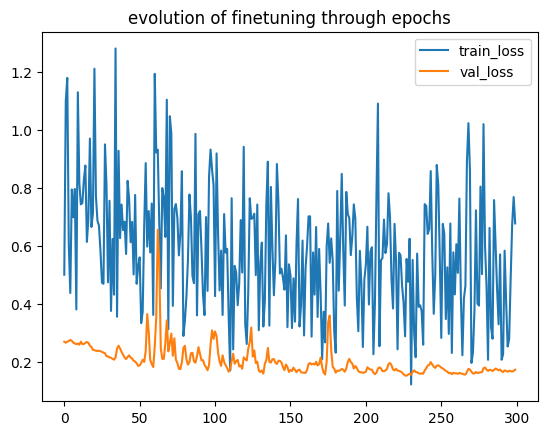

In [10]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = 'saved_models/masked_patchtst/finetuned_d128_losses.csv'
df = pd.read_csv(file_path)

plt.plot(df['train_loss'], label="train_loss")
plt.plot(df['valid_loss'], label="val_loss")
plt.legend()
plt.title("evolution of finetuning through epochs")

plt.show()


In [9]:
def test_func(args, weight_path):
    # get dataloader
    print('end-to-end finetuning')
    # get dataloader
    dls = get_dls(args, Rain_Ndvi_Dataset)
    # get model 
    model = get_model(args, head_type='prediction').to('cpu')
    
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=True)] if args.revin else []
    cbs += [PatchCB(patch_len=args.patch_len, stride=args.stride)]
    learn = Learner(dls, model,cbs=cbs)
    out  = learn.test(dls.test, weight_path=weight_path+'.pth', scores=[mse,mae])         # out: a list of [pred, targ, score]
    print('score:', out[2])
    # save results
    pd.DataFrame(np.array(out[2]).reshape(1,-1), columns=['mse','mae']).to_csv(args.save_path + args.save_finetuned_model + '_acc.csv', float_format='%.6f', index=False)
    return out, dls

In [10]:
out,dls = test_func(config_obj, config_obj.save_path + config_obj.save_finetuned_model)

end-to-end finetuning
(lat, lon) selected for test: (1433, 3905)
number of patches: 7
number of model params 802825
self.xb torch.Size([65, 36, 2]) self.yb torch.Size([65, 9, 2])
score: [array(0.4578907, dtype=float32), array(0.46396264, dtype=float32)]


In [11]:
pred, targ, score = out
gt = dls.test.dataset[0]

In [26]:
def visualize(inputs, targets, outputs, idx, feature_names, seq_len):
    
    mae_ndvi = mean_absolute_error(targets[:,1], outputs[:,1])
    mse_ndvi = mean_squared_error(targets[:,1], outputs[:,1])

    
    mae_rfh = mean_absolute_error(targets[:,0], outputs[:,0])
    mse_rfh = mean_squared_error(targets[:,0], outputs[:,0])

    # Select a sample from the batch to visualize

    # Detach and move to CPU for visualization
    inputs_sample = inputs.cpu().detach().numpy()
    targets_sample = targets.cpu().detach().numpy()
    outputs_sample = outputs.cpu().detach().numpy()
    # lta_sample = lta.cpu().detach().numpy()

    # Plotting
    plt.figure(figsize=(12,3 ),  facecolor='none')

    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)
        # Time axis
        time_input = np.arange(seq_len)
        time_future = np.arange(seq_len, seq_len + len(targets_sample))

        # Plot input, target, and output
        plt.plot(time_input, inputs_sample[:, i], label='Input')
        plt.plot(time_future, targets_sample[:, i], label='Target')
        plt.plot(time_future, outputs_sample[:, i], label='Prediction')
        if i==0:
            plt.title(f'Batch {idx+1}, {feature_name},  MAE={mae_rfh:.4f},    MSE={mse_rfh:.4f}')
        if i==1:
            plt.title(f'Batch {idx+1}, {feature_name},  MAE={mae_ndvi:.4f},    MSE={mse_ndvi:.4f}')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lat,lon = 2251, 4514
pred, targ, score = out

mse_ndvi_list=[]
mae_ndvi_list=[]

mse_rfh_list=[]
mae_rfh_list=[]

for idx in range(pred.shape[0]):
    
    inputs = dls.test.dataset[idx][0]
    targets= dls.test.dataset[idx][1]
    outputs = torch.Tensor(pred[idx])
    visualize(inputs, targets, outputs, idx, ['rain(mm)', 'ndvi'], config_obj.sequence_length)
    

# smooth output

In [8]:
from  hdc.algo.accessors import WhittakerSmoother

In [ ]:


def smooth(output):
    tensor = output

    # Convert tensor to numpy
    numpy_array = tensor.numpy()

    # Create a time dimension (assuming your tensor is time-series data)
    time_dim = pd.date_range(start='2020-01-01', periods=len(numpy_array))

    # Create an xarray DataArray
    data_array = xr.DataArray(numpy_array, coords=[time_dim], dims=["time"])

    # Apply the Whittaker smoother (example values for s and nodata)
    # Use the accessor directly on the xarray DataArray
    smoothed_data = data_array.hdc.whit.whits(nodata=-9999, s=1e-2, p=None)

    return smoothed_data.values



plt.plot(smooth(outputs[:,1]*1e3)/1e3, label="smoothed")
plt.plot(outputs[:,1], label="PatchTST")
plt.legend()

# Holtwinters


In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [13]:
def holtwinters_prediction(dls, index, verbose=False):
    '''
        return Tensor [pred_sequence,] denormalized
    '''
    tensors_to_concatenate = [dls.test.dataset[i][0] for i in range(index-10, index)]
    input_sequence_ndvi= dls.test.dataset.inverse_transform(torch.cat(tensors_to_concatenate, dim=0))[:,1]
    target_sequence_ndvi= dls.test.dataset.inverse_transform(dls.test.dataset[index][1])[:,1]
    
    if verbose:
        plt.plot(input_sequence_ndvi,label="input sequence")
        plt.plot(np.arange(input_sequence_ndvi.shape[0],input_sequence_ndvi.shape[0]+ target_sequence_ndvi.shape[0]),target_sequence_ndvi, label="target sequence")
        plt.legend()
        plt.title("input sequence for Holtwinters")
        plt.show()

    train_seq = input_sequence_ndvi
    test_seq = target_sequence_ndvi
    model = ExponentialSmoothing(train_seq, seasonal='add', seasonal_periods=36)
    model_fit = model.fit()
    pred_sequence = test_seq.shape[0]
    holtwinter = model_fit.forecast(pred_sequence)  
    
    return holtwinter 

# holtwinters_prediction(dls, index=13, verbose=True)

In [14]:
lat,lon = 1433, 3905

# for index in range(10,len(dls.test.dataset)) :

index=10

inputs = dls.test.dataset[index][0]
targets= dls.test.dataset[index][1]
outputs = torch.Tensor(pred[index])

In [ ]:
# smoothed_patchtst = smooth(torch.Tensor(dls.test.dataset.inverse_transform(outputs)[:,1]*1e3))/1e3
lta = torch.tensor(get_LTA (lat,lon,index, config['sequence_length'], config['prediction_length']))  
holtwinter = holtwinters_prediction(dls, index)

In [ ]:
inputs_sample = inputs.cpu().detach().numpy()
targets_sample = targets.cpu().detach().numpy()
outputs_sample = outputs.cpu().detach().numpy()
lta_sample = lta.cpu().detach().numpy()



mae_patchtst = mean_absolute_error(dls.test.dataset.inverse_transform(targets)[:,1], dls.test.dataset.inverse_transform(outputs)[:,1])
mse_patchtst = mean_squared_error(dls.test.dataset.inverse_transform(targets)[:,1], dls.test.dataset.inverse_transform(outputs)[:,1])

# mae_smoothed = mean_absolute_error(dls.test.dataset.inverse_transform(targets)[:,1], smoothed_patchtst)
# mse_smoothed = mean_squared_error(dls.test.dataset.inverse_transform(targets)[:,1], smoothed_patchtst)


mae_hw = mean_absolute_error(holtwinter, dls.test.dataset.inverse_transform(outputs)[:,1])
mse_hw = mean_squared_error(holtwinter, dls.test.dataset.inverse_transform(outputs)[:,1])

mae_lta = mean_absolute_error(lta, dls.test.dataset.inverse_transform(outputs)[:,1])
mse_lta = mean_squared_error(lta, dls.test.dataset.inverse_transform(outputs)[:,1])




time_input = np.arange(config["sequence_length"])
time_future = np.arange(config["sequence_length"], config["sequence_length"] + config["prediction_length"])


plt.plot(time_input, dls.test.dataset.inverse_transform(inputs_sample)[:, 1], label='Input')
plt.plot(time_future, dls.test.dataset.inverse_transform(targets_sample)[:, 1], label='Target')
plt.plot(time_future, dls.test.dataset.inverse_transform(outputs_sample)[:, 1], label=f'Prediction     MAE={mae_patchtst:.4f},    MSE={mse_patchtst:.4f}')
# plt.plot(time_future, smoothed_patchtst, label=f'Smoothed_patchtst    MAE={mae_smoothed:.4f},    MSE={mse_smoothed:.4f}')
plt.plot(time_future, holtwinter, label=f'holtwinter     MAE={mae_hw:.4f},    MSE={mse_hw:.4f}')
plt.plot(time_future, lta_sample, label=f'LTA     MAE={mae_lta:.4f},    MSE={mse_lta:.4f}')

plt.legend()
plt.title("Comparaison")
plt.show()




In [33]:
# Example: Selecting a subset or aggregating data
# Replace 'latitude_value' and 'longitude_value' with specific values or ranges as needed
latitude_value, longitude_value = 1118, 1887
selected_ndvi = NDVI.isel(latitude=latitude_value, longitude=longitude_value)
# Converting xarray DataArray to pandas DataFrame
df_ndvi = selected_ndvi.to_dataframe().reset_index()['band']

In [34]:
def visualize_comparaison(inputs, targets, outputs,lta, holtwinter, idx, feature_names, seq_len):
    # Select a sample from the batch to visualize

    # Detach and move to CPU for visualization
    inputs_sample = inputs.cpu().detach().numpy()
    targets_sample = targets.cpu().detach().numpy()
    outputs_sample = outputs.cpu().detach().numpy()
    lta_sample = lta.cpu().detach().numpy()

    # Plotting
    plt.figure(figsize=(12,3 ),  facecolor='none')

    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)
        # Time axis
        time_input = np.arange(seq_len)
        time_future = np.arange(seq_len, seq_len + len(targets_sample))

        # Plot input, target, and output
        plt.plot(time_input, inputs_sample[:, i], label='Input')
        plt.plot(time_future, targets_sample[:, i], label='Target')
        plt.plot(time_future, outputs_sample[:, i], label='Prediction')
        plt.plot(time_future, lta_sample, label='LTA')
        
        if i ==1 : 
            plt.plot(time_future, holtwinter.index, label='Holtwinter')
            
            
            

        plt.title(f'Batch {idx+1}, {feature_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lat,lon = 1025, 5480

input_sequence = config['sequence_length']
pred_sequence = config['prediction_length']

pred, targ, score = out

mse_ndvi_list=[]
mae_ndvi_list=[]

mse_rfh_list=[]
mae_rfh_list=[]

for idx in range(pred.shape[0]):
    
    inputs = dls.test.dataset[idx][0]
    targets= dls.test.dataset[idx][1]
    outputs = torch.Tensor(pred[idx])
    # lta = torch.tensor(get_LTA (lat,lon,idx, config['sequence_length'], config['prediction_length']))  

    
    
#     train_seq = pd.DataFrame(inputs[:,1].numpy())
#     test_seq = pd.DataFrame(targets[:,1].numpy())
#     model = ExponentialSmoothing(train_seq, seasonal='add', seasonal_periods=18)
#     model_fit = model.fit()
#     holtwinter = model_fit.forecast(pred_sequence)  
    
    
    
    # Plotting
    plt.figure(figsize=(10, 4))
    # plt.plot(train_seq.index, train_seq, label='Training Data')
    # plt.plot(test_seq.index +len(train_seq.index) , test_seq, label='Actual NDVI')
    # plt.plot(test_seq.index +len(train_seq.index), holtwinter, label='Holtwinter')
    plt.title(f'NDVI Forecast Normalized')
    plt.xlabel('Time')
    plt.ylabel('NDVI')
    
    
    
    # Detach and move to CPU for visualization
    inputs_sample = inputs.cpu().detach().numpy()
    targets_sample = targets.cpu().detach().numpy()
    outputs_sample = outputs.cpu().detach().numpy()
    # lta_sample = lta#.cpu().detach().numpy()

    # Time axis
    time_input = np.arange(config_obj.sequence_length)
    time_future = np.arange(config_obj.sequence_length, config_obj.sequence_length + len(targets_sample))
    
    

    # Plot input, target, and output
    plt.plot(time_input, inputs_sample[:, 1], label='Input')
    plt.plot(time_future, targets_sample[:, 1], label='Target')
    plt.plot(time_future, outputs_sample[:, 1], label='PatchTST')
    # plt.plot(time_future, lta_sample, label='LTA')
    plt.legend()
    plt.show()
    
#     lta = torch.Tensor(get_LTA (lat,lon,idx, config['sequence_length'], config['prediction_length']))


    
#     mae_ndvi = mean_absolute_error(targets[:,1], outputs[:,1])
#     mse_ndvi = mean_squared_error(targets[:,1], outputs[:,1])
#     mse_ndvi_list.append(mse_ndvi)
#     mae_ndvi_list.append(mae_ndvi)
    
#     mae_rfh = mean_absolute_error(targets[:,0], outputs[:,0])
#     mse_rfh = mean_squared_error(targets[:,0], outputs[:,0])
#     mse_rfh_list.append(mse_rfh)
#     mae_rfh_list.append(mae_rfh)
    
    
    
#     visualize_comparaison(inputs, targets, outputs, lta, holtwinter, idx, ['rain(mm)', 'ndvi'], config_obj.sequence_length)
    

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# lat,lon = 1088, 1293

input_sequence = config['sequence_length']
pred_sequence = config['prediction_length']

pred, targ, score = out

mse_ndvi_list=[]
mae_ndvi_list=[]

mse_rfh_list=[]
mae_rfh_list=[]

for idx in range(pred.shape[0]):
    
    inputs = dls.test.dataset[idx][0]
    targets= dls.test.dataset[idx][1]
    outputs = torch.Tensor(pred[idx])
    lta = torch.tensor(get_LTA (lat,lon,idx, config['sequence_length'], config['prediction_length']))  

    
    
#     train_seq = pd.DataFrame(inputs[:,1].numpy())
#     test_seq = pd.DataFrame(targets[:,1].numpy())
#     model = ExponentialSmoothing(train_seq, seasonal='add', seasonal_periods=18)
#     model_fit = model.fit()
#     holtwinter = model_fit.forecast(pred_sequence)  
    
    
    
    # Plotting
    plt.figure(figsize=(10, 4))
    # plt.plot(train_seq.index, train_seq, label='Training Data')
    # plt.plot(test_seq.index +len(train_seq.index) , test_seq, label='Actual NDVI')
    # plt.plot(test_seq.index +len(train_seq.index), holtwinter, label='Holtwinter')
    plt.title(f'NDVI Forecast Denormalized')
    plt.xlabel('Time')
    plt.ylabel('NDVI')
    
    
    
    # Detach and move to CPU for visualization
    inputs_sample = inputs.cpu().detach().numpy()
    targets_sample = targets.cpu().detach().numpy()
    outputs_sample = outputs.cpu().detach().numpy()
    lta_sample = lta#.cpu().detach().numpy()

    # Time axis
    time_input = np.arange(config_obj.sequence_length)
    time_future = np.arange(config_obj.sequence_length, config_obj.sequence_length + len(targets_sample))
    
    

    # Plot input, target, and output
    plt.plot(time_input, dls.test.dataset.inverse_transform(inputs_sample)[:, 1], label='Input')
    plt.plot(time_future, dls.test.dataset.inverse_transform(targets_sample)[:, 1], label='Target')
    plt.plot(time_future, dls.test.dataset.inverse_transform(outputs_sample)[:, 1], label='PatchTST')
    plt.plot(time_future, lta_sample, label='LTA')
    plt.legend()
    plt.show()
    
#     lta = torch.Tensor(get_LTA (lat,lon,idx, config['sequence_length'], config['prediction_length']))


    
#     mae_ndvi = mean_absolute_error(targets[:,1], outputs[:,1])
#     mse_ndvi = mean_squared_error(targets[:,1], outputs[:,1])
#     mse_ndvi_list.append(mse_ndvi)
#     mae_ndvi_list.append(mae_ndvi)
    
#     mae_rfh = mean_absolute_error(targets[:,0], outputs[:,0])
#     mse_rfh = mean_squared_error(targets[:,0], outputs[:,0])
#     mse_rfh_list.append(mse_rfh)
#     mae_rfh_list.append(mae_rfh)
    
    
    
#     visualize_comparaison(inputs, targets, outputs, lta, holtwinter, idx, ['rain(mm)', 'ndvi'], config_obj.sequence_length)
    

# Compare

In [1]:
import sys
sys.path.append("./PatchTST_self_supervised/")
from types import SimpleNamespace
import xarray as xr
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np


from PatchTST_self_supervised.src.models.patchTST import PatchTST
from PatchTST_self_supervised.src.learner import Learner, transfer_weights
from PatchTST_self_supervised.src.callback.tracking import *
from PatchTST_self_supervised.src.callback.patch_mask import *
from PatchTST_self_supervised.src.callback.transforms import *
from PatchTST_self_supervised.src.metrics import *
from PatchTST_self_supervised.src.basics import set_device
from PatchTST_self_supervised.datautils import *

from src.data.datamodule import DataLoaders

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
out = torch.load("saved_models/denorm_Africa_Forecast/out_100_200.pt")
pred, targ = out[0], out[1]

In [16]:
PATH = "./"

ds_full = xr.open_zarr("s3://wfp-ops-userdata/public-share/ndvi_world.zarr")

new_time_chunk_size = -1
new_latitude_chunk_size = 50
new_longitude_chunk_size = 50
target_chunks = {'time':
                 new_time_chunk_size, 'latitude': new_latitude_chunk_size, 'longitude': new_longitude_chunk_size}

max_mem = "12GB"

time_step_size = 30  # Define batch size
num_batches = ds_full.dims['time'] // time_step_size


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'NDVI Rechunked/ndvi_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

NDVI = xr.concat(concatenated_ds_list, dim='time')


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'RFH Rechunked/rfh_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

# Concatenate all datasets along the time dimension
RFH = xr.concat(concatenated_ds_list, dim='time')


In [49]:

NDVI_lta = NDVI_africa.sel(time=slice("2003-02-01","2018-12-31"))
NDVI_lta  = NDVI_lta .groupby(NDVI_lta.time.dt.strftime("%m-%d")).mean()
NDVI_lta = NDVI_lta.sel(strftime=NDVI.time.dt.strftime("%m-%d"))

RFH_lta = RFH_africa.sel(time=slice("2003-02-01","2018-12-31"))
RFH_lta  = RFH_lta .groupby(RFH_lta.time.dt.strftime("%m-%d")).mean()
RFH_lta = RFH_lta.sel(strftime=RFH.time.dt.strftime("%m-%d"))


In [17]:
bbox_africa = [-17.314453,-34.957995,51.855469,13.667338]
NDVI_africa =NDVI.sel(
    latitude=slice(bbox_africa[3], bbox_africa[1]),
    longitude=slice(bbox_africa[0], bbox_africa[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)


RFH_africa =RFH.sel(
    latitude=slice(bbox_africa[3], bbox_africa[1]),
    longitude=slice(bbox_africa[0], bbox_africa[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)

In [19]:
ndvi_array = NDVI_africa.band.values
rfh_array = RFH_africa.band.values
time_array = RFH_africa.time.values

def get_dls(config_obj, dataset_class,lat,lon):
    size = [config_obj.sequence_length, 0, config_obj.prediction_length]
    dls = DataLoaders(
            datasetCls=dataset_class,
            dataset_kwargs={
                'ndvi_array':ndvi_array , 
                'rfh_array':rfh_array ,
                'time_array':time_array ,
                'size':size,
                'scale':True,
                'lat_index': lat,
                'lon_index': lon
            },
            batch_size=config_obj.batch_size,
            workers=config_obj.num_workers,
            )

    dls.vars, dls.len = dls.train.dataset[0][0].shape[1], config_obj.sequence_length
    dls.c = dls.train.dataset[0][1].shape[0]
    return dls

In [29]:
lat,lon = 100,200
out = torch.load("saved_models/Africa_forecast//out_100_200.pt")
pred, targ = out[0], out[1]
dls = get_dls(config_obj, Rain_Ndvi_Dataset,lat,lon)

(lat, lon) selected for test: (100, 200)


In [18]:
# # Finetune

# +
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 3e-4,
    
    'batch_size':128, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 200, # number of pre-training epochs
    'n_epochs_finetune' : 400, # number of pre-training epochs
    'pretrained_model_id': 1, # id of the saved pretrained model
    
    
    'save_finetuned_model': './finetuned_d128',
    
    'save_path' :  'saved_models' + '/masked_patchtst/'
    
}

config_obj = SimpleNamespace(**config)


# +
class Rain_Ndvi_Dataset(Dataset):
    def __init__(self, ndvi_array, rfh_array,time_array, lat_index,lon_index, size=None, split='train', scale=True):
        if size is None:
            self.seq_len = 30
            self.label_len = 10
            self.pred_len = 10
        else:
            self.seq_len, self.label_len, self.pred_len = size
            
        assert split in ['train', 'val', 'test']
        self.split = split
        self.scale = scale
        # self.ndvi_xarray = ndvi_xarray
        # self.rfh_xarray = rfh_xarray
        self.ndvi_array = ndvi_array
        self.rfh_array = rfh_array
        self.time_array = time_array
        self.features = ['rfh', 'ndvi']
        self.lat_index = lat_index
        self.lon_index = lon_index


        self.initialize_data_for_epoch()

    def initialize_data_for_epoch(self):
        # Randomly select a pixel
        lat, lon = self.select_random_pixel()
        
        # while np.isnan(self.ndvi_xarray.isel(latitude=lat, longitude=lon, time=0).band.values) or np.isnan(self.rfh_xarray.isel(latitude=lat, longitude=lon, time=0).band.values):
        #     lat, lon = self.select_random_pixel()
        # Generate DataFrame for the selected pixel
        if self.split == "test":
            print("(lat, lon) selected for test:",  (lat, lon))
            
        self.dataframe = self.generate_pixel_dataframe(lat, lon)
        # Read and split data
        self.__read_data__()

    def select_random_pixel(self):
        lat = self.lat_index
        lon = self.lon_index
        return lat, lon

    def generate_pixel_dataframe(self, lat, lon):
        ndvi_df = pd.DataFrame(self.ndvi_array[:,lat,lon], columns=['band'])
        time_values = self.time_array  
        ndvi_df = ndvi_df.reset_index()
        ndvi_df['time'] = time_values
        ndvi = ndvi_df[['time', 'band']]
        ndvi.rename(columns={'band': 'ndvi'}, inplace=True)
        ndvi.set_index('time', inplace=True)
        
        
        rfh_df = pd.DataFrame(self.rfh_array[:,lat,lon], columns=['band'])
        time_values = self.time_array  
        rfh_df = rfh_df.reset_index()
        rfh_df['time'] = time_values
        rfh = rfh_df[['time', 'band']]
        rfh.rename(columns={'band': 'rfh'}, inplace=True)
        rfh.set_index('time', inplace=True)
        df = pd.concat([rfh, ndvi], axis=1)
        return df

    def __read_data__(self):
        df = self.dataframe.copy()

        if self.scale:
            self.scaler = StandardScaler()
            df[self.features] = self.scaler.fit_transform(df[self.features])
            

        train_size = int(0.7 * len(df))
        val_size = int(0.15 * len(df))

        if self.split == 'train':
            self.data = df.iloc[:train_size]
        elif self.split == 'val':
            self.data = df.iloc[train_size:train_size + val_size]
        else:
            self.data = df.iloc[train_size + val_size:]

    def __getitem__(self, index):
        # Choose a random start index for the sequence
        max_start_index = len(self.data) - self.seq_len - self.pred_len
        if max_start_index < 1:
            raise ValueError("Dataset is too small for the specified sequence and prediction lengths.")
        random_start = np.random.randint(0, max_start_index)

        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end 
        r_end = r_begin + self.pred_len
        

        seq_x = self.data.iloc[s_begin:s_end][self.features].values
        seq_y = self.data.iloc[r_begin:r_end][self.features].values


        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        if self.scale:
            return self.scaler.inverse_transform(data)
        return data

# Example of how to use the class:
# NDVI = xr.open_dataarray("path_to_ndvi.nc")
# RFH = xr.open_dataarray("path_to_rfh.nc")
# dataset = Rain_Ndvi_Dataset(NDVI, RFH, split='train')
# During training, call dataset.initialize_data_for_epoch() at the beginning of each epoch


# +
def get_model(args, head_type, weight_path=None):
    """
    c_in: number of variables
    """
    # get number of patches
    num_patch = (max(args.sequence_length, args.patch_len)-args.patch_len) // args.stride + 1    
    print('number of patches:', num_patch)
    
    # get model
    model = PatchTST(c_in=args.c_in,
                target_dim=args.prediction_length,
                patch_len=args.patch_len,
                stride=args.stride,
                num_patch=num_patch,
                n_layers=4, #number of Transformer layers
                n_heads=16,#number of Transformer heads
                d_model= 128, #128, #Transformer d_model
                shared_embedding=True,
                d_ff=512, #Tranformer MLP dimension                              
                dropout=2e-1, #Transformer dropout
                head_dropout=2e-1, #head dropout
                act='relu',
                head_type=head_type,
                res_attention=False
                )    
    if weight_path: model = transfer_weights(weight_path, model)
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model



In [67]:
def holtwinters_prediction(dls, index, verbose=False, variable=1):
    '''
        return Tensor [pred_sequence,] denormalized
    '''
    print(dls.test.dataset[i][0].shape)
    tensors_to_concatenate = [dls.test.dataset[i][0] for i in range(index-10, index)]
    print(torch.cat(tensors_to_concatenate, dim=0).shape)
    input_sequence_ndvi= dls.test.dataset.inverse_transform(torch.cat(tensors_to_concatenate, dim=0))[:,variable]
    target_sequence_ndvi= dls.test.dataset.inverse_transform(dls.test.dataset[index][1])[:,variable]
    
    if verbose:
        plt.plot(input_sequence_ndvi,label="input sequence")
        plt.plot(np.arange(input_sequence_ndvi.shape[0],input_sequence_ndvi.shape[0]+ target_sequence_ndvi.shape[0]),target_sequence_ndvi, label="target sequence")
        plt.legend()
        plt.title("input sequence for Holtwinters")
        plt.show()

    train_seq = input_sequence_ndvi
    test_seq = target_sequence_ndvi
    model = ExponentialSmoothing(train_seq, seasonal='add', seasonal_periods=36)
    model_fit = model.fit()
    pred_sequence = test_seq.shape[0]
    holtwinter = model_fit.forecast(pred_sequence)  
    
    return holtwinter 

In [52]:


# rfh_lta = RFH_lta.isel(time=slice(r_begin-1,r_end-1),latitude=lat,longitude=lon).band.values
# ndvi_lta = NDVI_lta.isel(time=slice(r_begin-1,r_end-1),latitude=lat,longitude=lon ).band.values



rfh_lta = RFH_lta.isel(latitude=lat,longitude=lon).band.values
ndvi_lta = NDVI_lta.isel(latitude=lat,longitude=lon ).band.values


In [61]:
# Assuming dls.test.dataset.data is your DataFrame
df = dls.test.dataset.data

# Convert the index to a column
df_reset = df.reset_index()

# Now the time column is accessible as df_reset['time']
time_column = df_reset['time']
time_column

0     2019-06-21
1     2019-07-01
2     2019-07-11
3     2019-07-21
4     2019-08-01
         ...    
104   2022-05-11
105   2022-05-21
106   2022-06-01
107   2022-06-11
108   2022-06-21
Name: time, Length: 109, dtype: datetime64[ns]

torch.Size([36, 2])
torch.Size([360, 2])


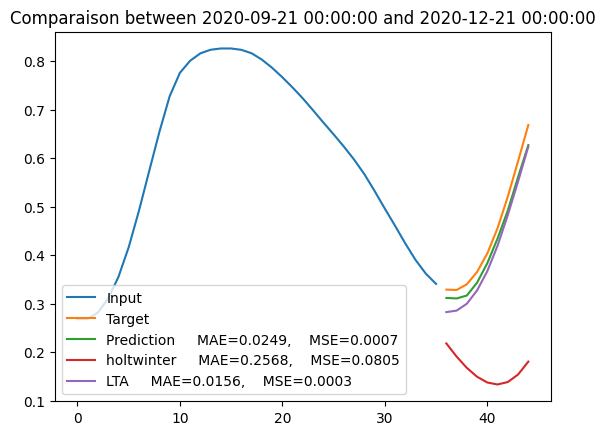

torch.Size([36, 2])
torch.Size([360, 2])


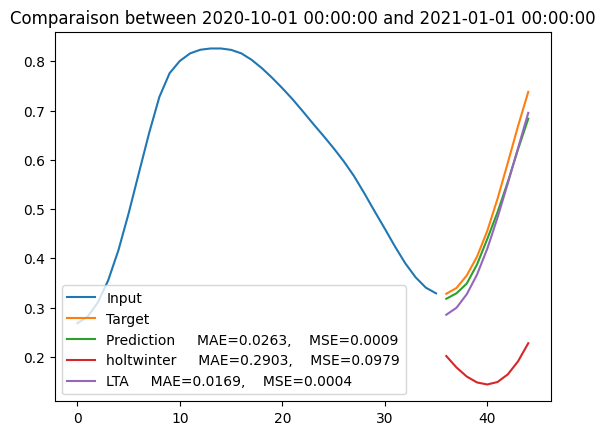

torch.Size([36, 2])
torch.Size([360, 2])


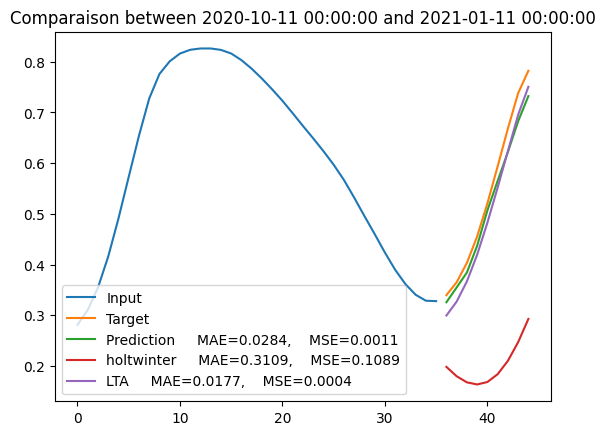

torch.Size([36, 2])
torch.Size([360, 2])


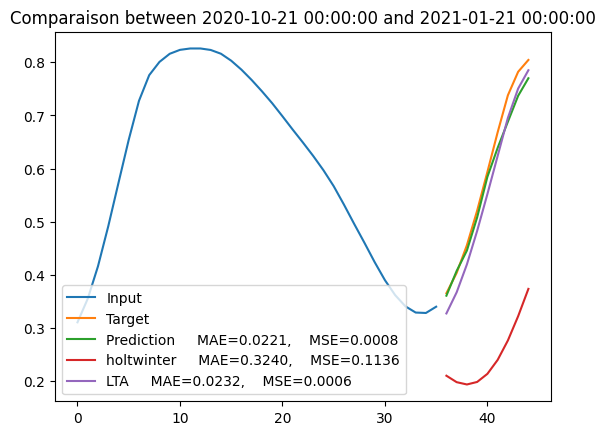

torch.Size([36, 2])
torch.Size([360, 2])


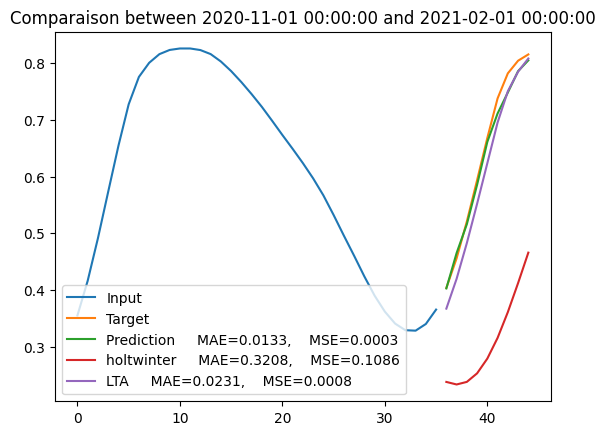

torch.Size([36, 2])
torch.Size([360, 2])


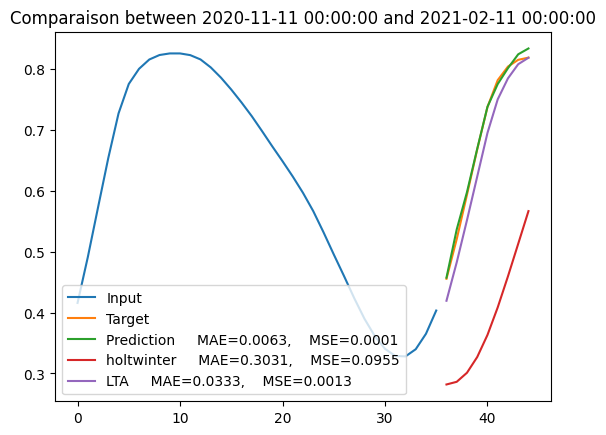

torch.Size([36, 2])
torch.Size([360, 2])


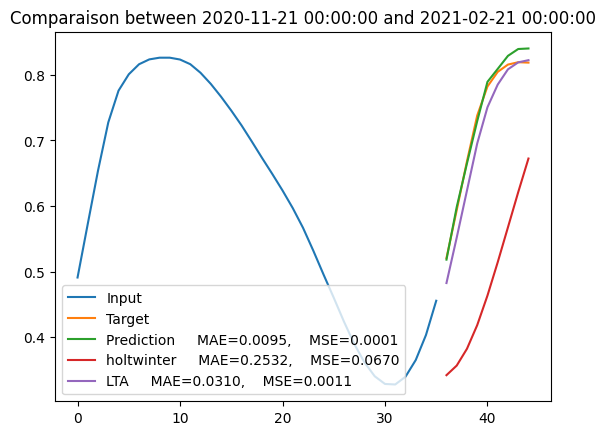

torch.Size([36, 2])
torch.Size([360, 2])


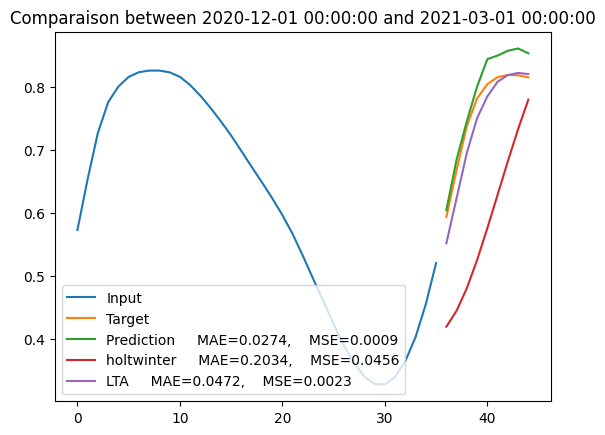

torch.Size([36, 2])
torch.Size([360, 2])


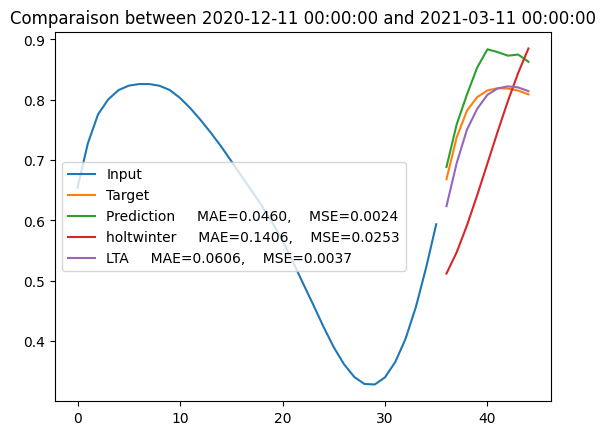

torch.Size([36, 2])
torch.Size([360, 2])


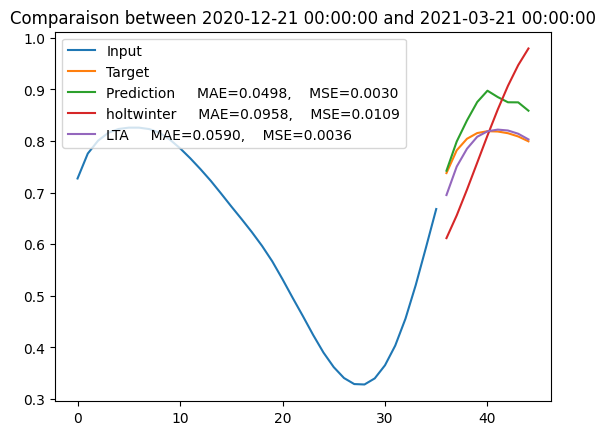

torch.Size([36, 2])
torch.Size([360, 2])


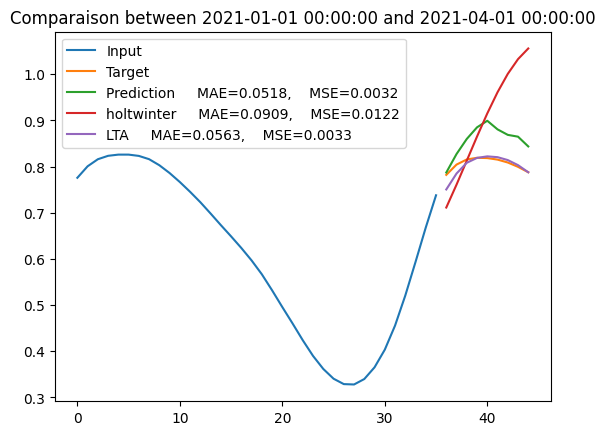

torch.Size([36, 2])
torch.Size([360, 2])


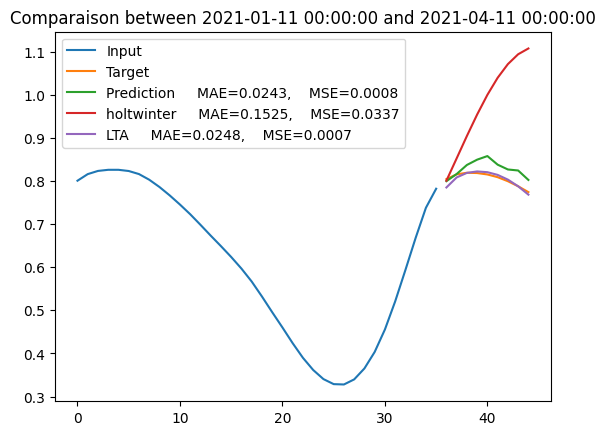

torch.Size([36, 2])
torch.Size([360, 2])


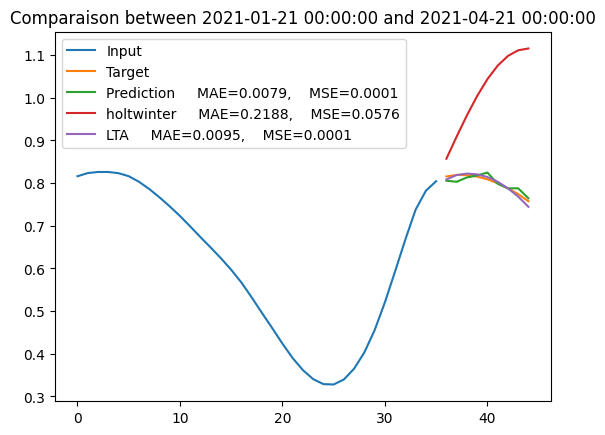

torch.Size([36, 2])
torch.Size([360, 2])


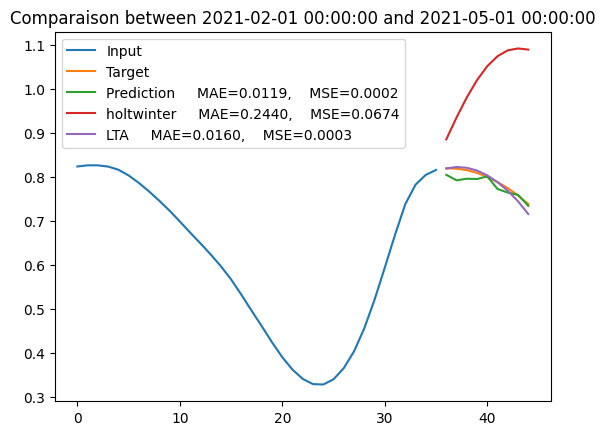

torch.Size([36, 2])
torch.Size([360, 2])


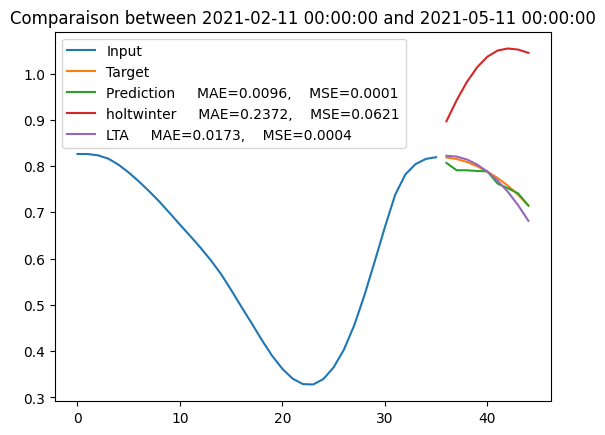

torch.Size([36, 2])
torch.Size([360, 2])


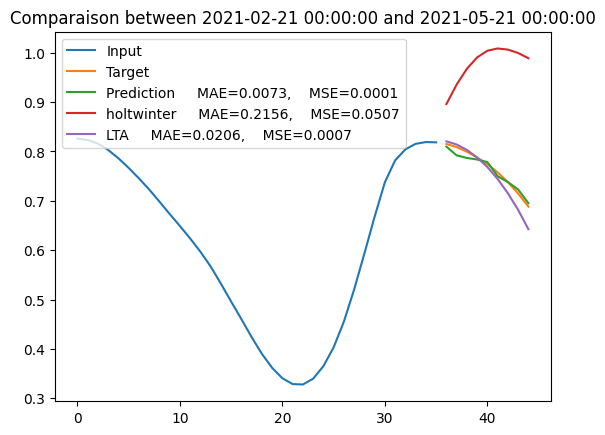

torch.Size([36, 2])
torch.Size([360, 2])


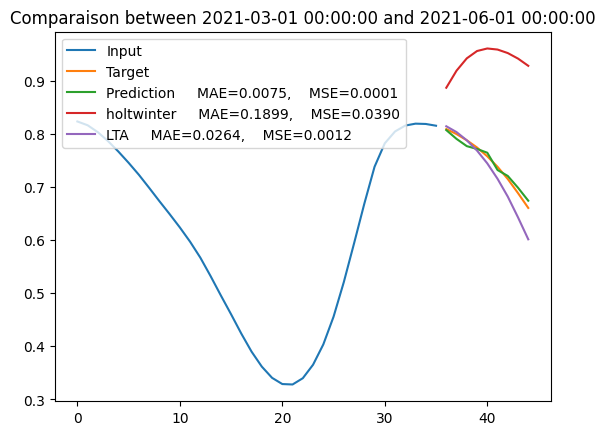

torch.Size([36, 2])
torch.Size([360, 2])


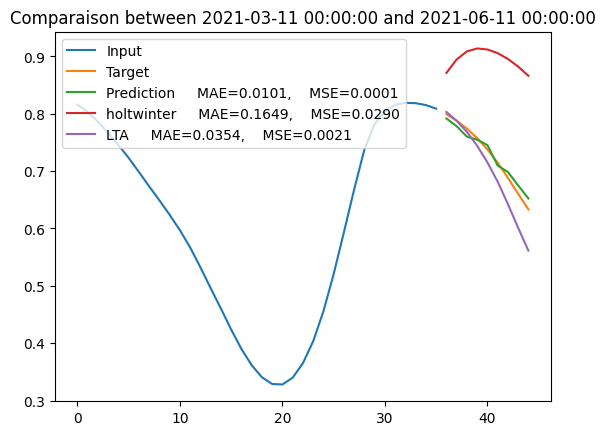

torch.Size([36, 2])
torch.Size([360, 2])


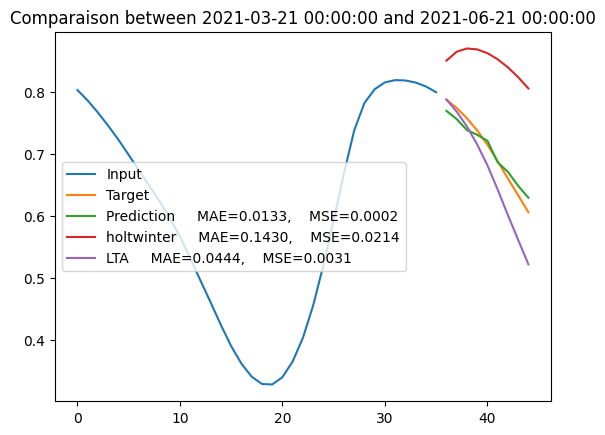

torch.Size([36, 2])
torch.Size([360, 2])


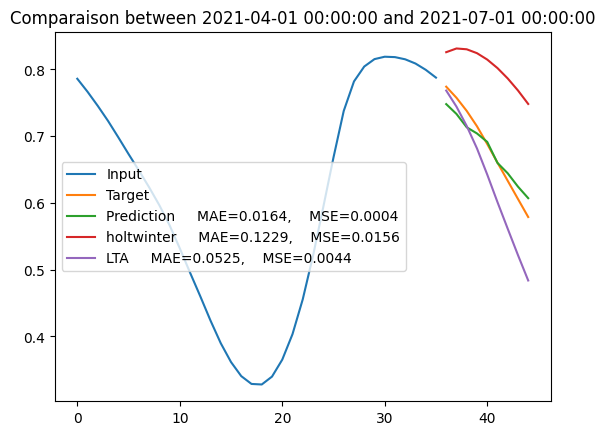

torch.Size([36, 2])
torch.Size([360, 2])


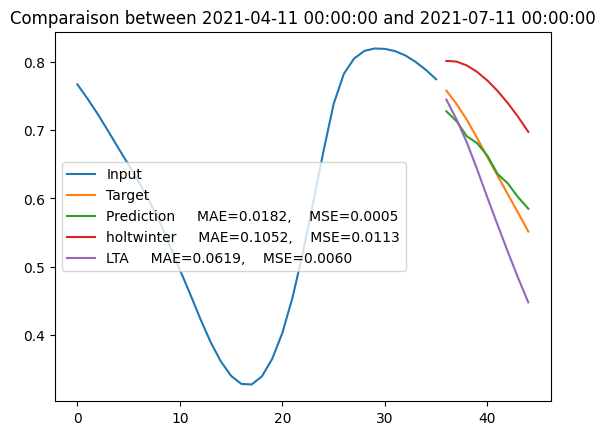

torch.Size([36, 2])
torch.Size([360, 2])


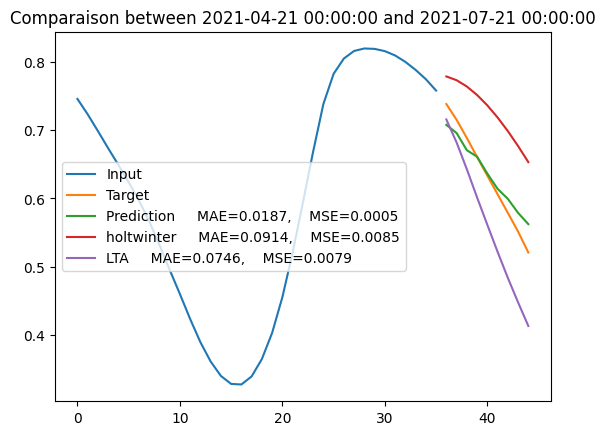

torch.Size([36, 2])
torch.Size([360, 2])


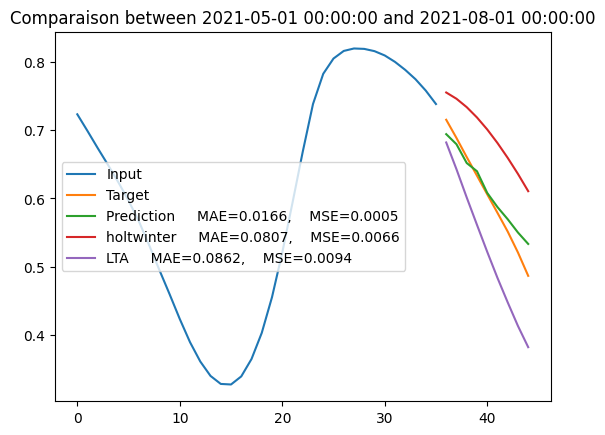

torch.Size([36, 2])
torch.Size([360, 2])


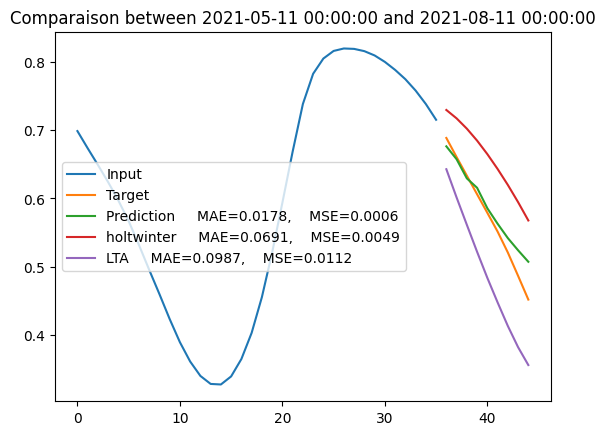

torch.Size([36, 2])
torch.Size([360, 2])


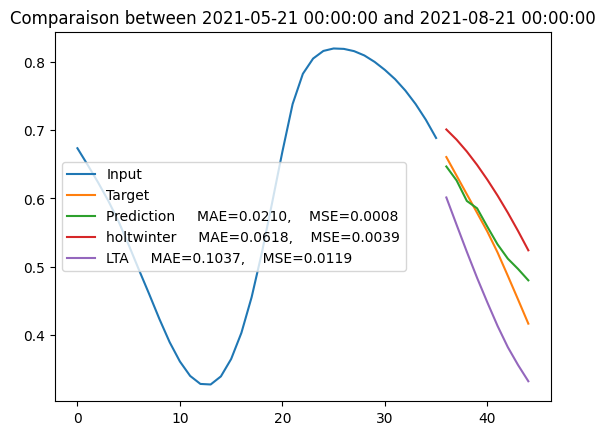

torch.Size([36, 2])
torch.Size([360, 2])


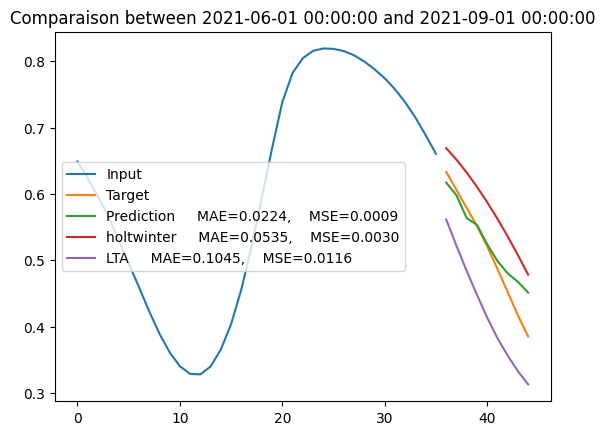

torch.Size([36, 2])
torch.Size([360, 2])


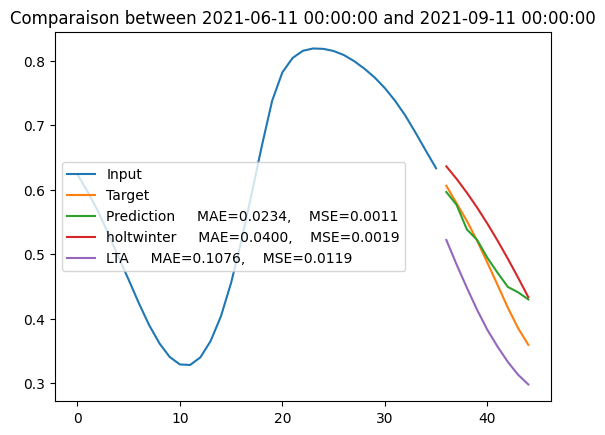

torch.Size([36, 2])
torch.Size([360, 2])


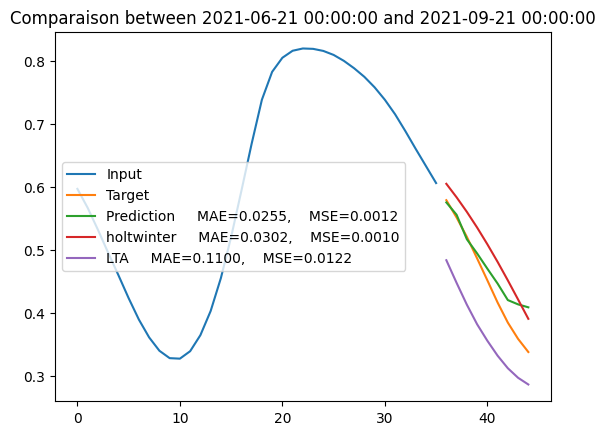

torch.Size([36, 2])
torch.Size([360, 2])


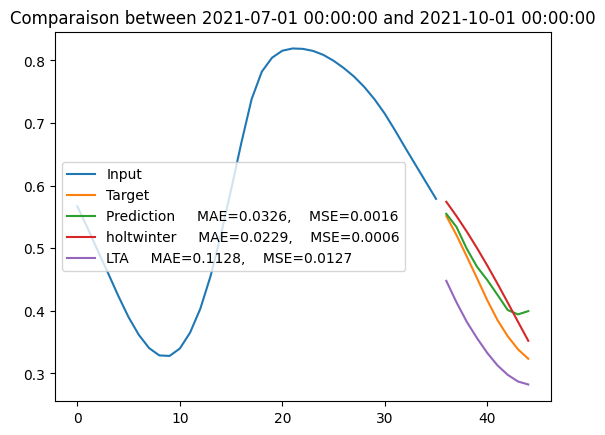

torch.Size([36, 2])
torch.Size([360, 2])


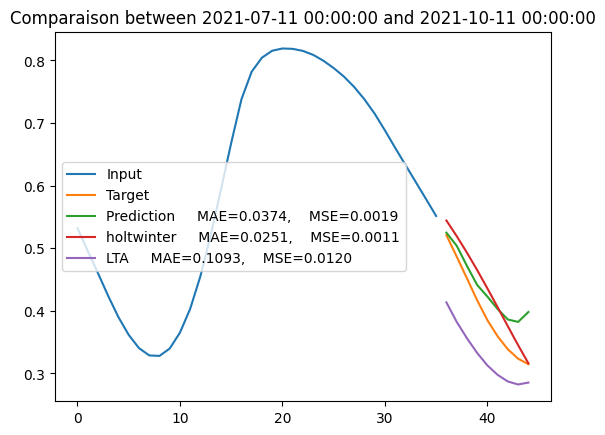

torch.Size([36, 2])
torch.Size([360, 2])


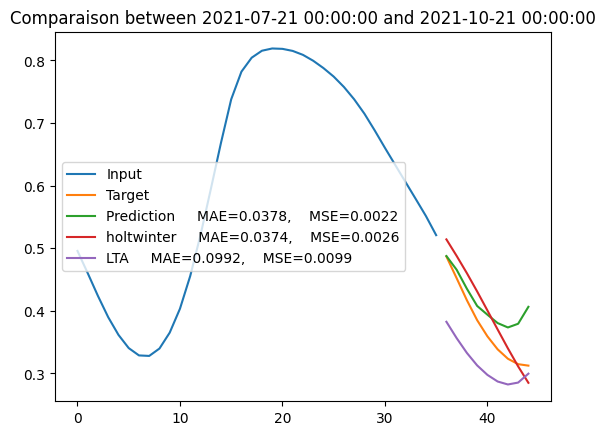

torch.Size([36, 2])
torch.Size([360, 2])


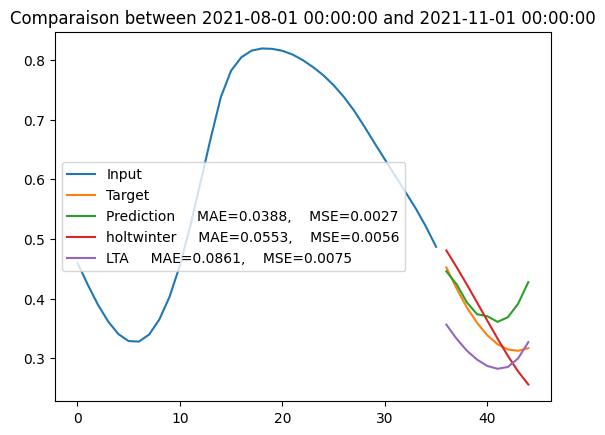

torch.Size([36, 2])
torch.Size([360, 2])


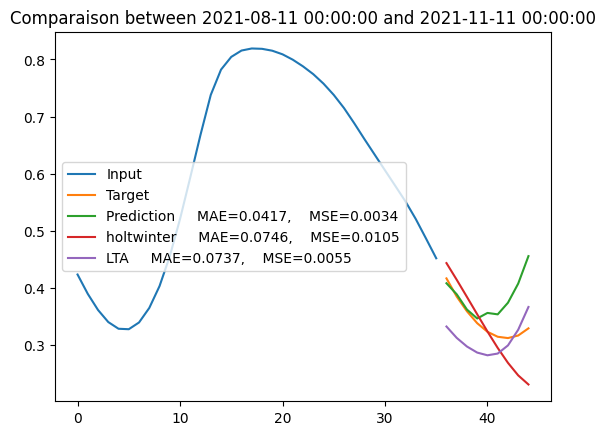

torch.Size([36, 2])
torch.Size([360, 2])


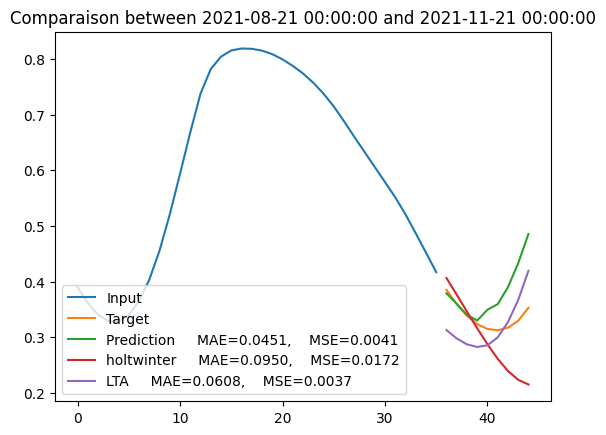

torch.Size([36, 2])
torch.Size([360, 2])


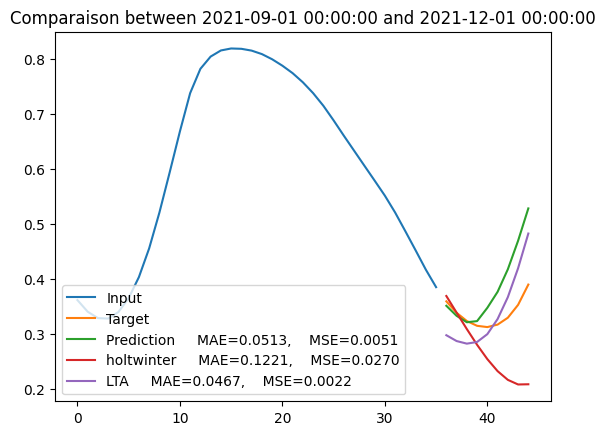

torch.Size([36, 2])
torch.Size([360, 2])


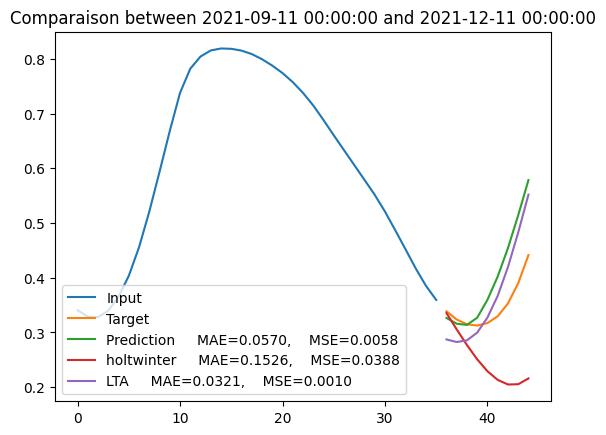

torch.Size([36, 2])
torch.Size([360, 2])


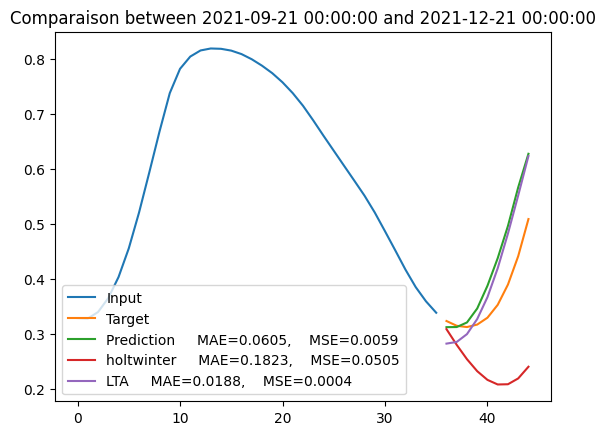

torch.Size([36, 2])
torch.Size([360, 2])


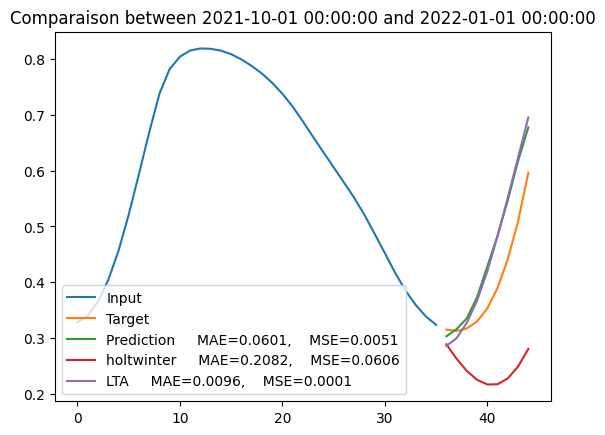

torch.Size([36, 2])
torch.Size([360, 2])


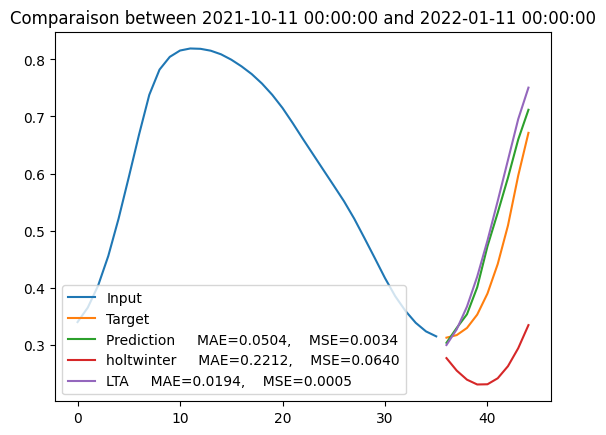

torch.Size([36, 2])
torch.Size([360, 2])


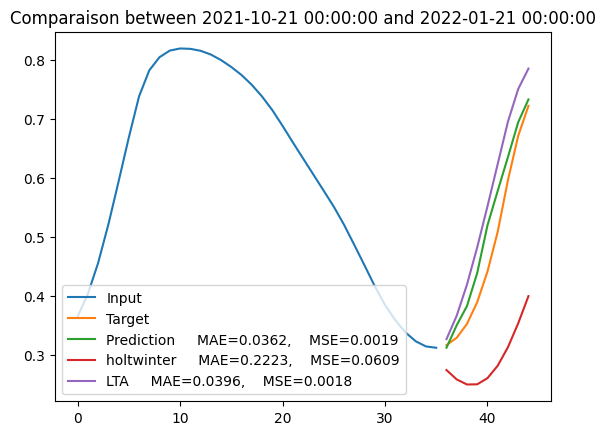

In [65]:
for index in range(10,50):
    inputs = dls.test.dataset[index][0]
    targets= dls.test.dataset[index][1]
    outputs = torch.Tensor(pred[index])

    # smoothed_patchtst = smooth(torch.Tensor(dls.test.dataset.inverse_transform(outputs)[:,1]*1e3))/1e3
    # lta = torch.tensor(get_LTA (lat,lon,index, config['sequence_length'], config['prediction_length']))  
    holtwinter = holtwinters_prediction(dls, index)

    inputs_sample = inputs.cpu().detach().numpy()
    targets_sample = targets.cpu().detach().numpy()
    outputs_sample = outputs.cpu().detach().numpy()
    # lta_sample = lta.cpu().detach().numpy()
    s_begin = index
    s_end = s_begin + config_obj.sequence_length
    r_begin = s_end 
    r_end = r_begin + config_obj.prediction_length
    
    lta_sample=ndvi_lta[r_begin-1:r_end-1]
    





    mae_patchtst = mean_absolute_error(dls.test.dataset.inverse_transform(targets)[:,1], dls.test.dataset.inverse_transform(outputs)[:,1])
    mse_patchtst = mean_squared_error(dls.test.dataset.inverse_transform(targets)[:,1], dls.test.dataset.inverse_transform(outputs)[:,1])

   

    mae_hw = mean_absolute_error(holtwinter, dls.test.dataset.inverse_transform(outputs)[:,1])
    mse_hw = mean_squared_error(holtwinter, dls.test.dataset.inverse_transform(outputs)[:,1])

    mae_lta = mean_absolute_error(lta_sample, dls.test.dataset.inverse_transform(outputs)[:,1])
    mse_lta = mean_squared_error(lta_sample, dls.test.dataset.inverse_transform(outputs)[:,1])




    time_input = np.arange(config["sequence_length"])
    time_future = np.arange(config["sequence_length"], config["sequence_length"] + config["prediction_length"])


    plt.plot(time_input, dls.test.dataset.inverse_transform(inputs_sample)[:, 1], label='Input')
    plt.plot(time_future, dls.test.dataset.inverse_transform(targets_sample)[:, 1], label='Target')
    plt.plot(time_future, dls.test.dataset.inverse_transform(outputs_sample)[:, 1], label=f'Prediction     MAE={mae_patchtst:.4f},    MSE={mse_patchtst:.4f}')
    # plt.plot(time_future, smoothed_patchtst, label=f'Smoothed_patchtst    MAE={mae_smoothed:.4f},    MSE={mse_smoothed:.4f}')
    plt.plot(time_future, holtwinter, label=f'holtwinter     MAE={mae_hw:.4f},    MSE={mse_hw:.4f}')
    plt.plot(time_future, lta_sample, label=f'LTA     MAE={mae_lta:.4f},    MSE={mse_lta:.4f}')

    plt.legend()
    plt.title(f"Comparaison between {time_column[r_begin-1]} and {time_column[r_end-1]}")

    plt.savefig("comparaison")
    plt.show()

torch.Size([36, 2])
torch.Size([360, 2])


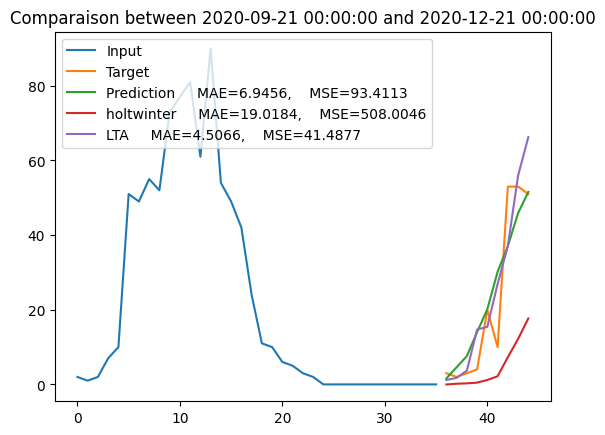

torch.Size([36, 2])
torch.Size([360, 2])


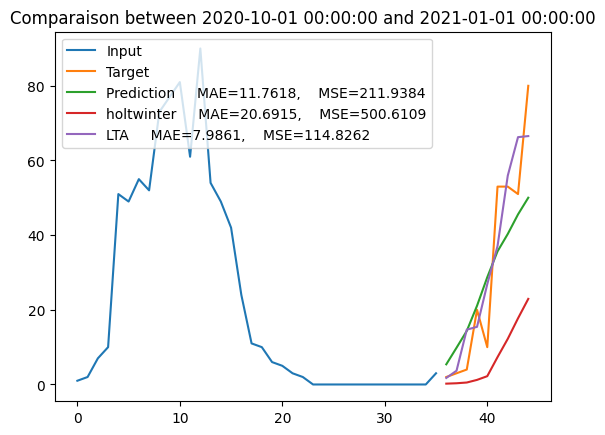

torch.Size([36, 2])
torch.Size([360, 2])


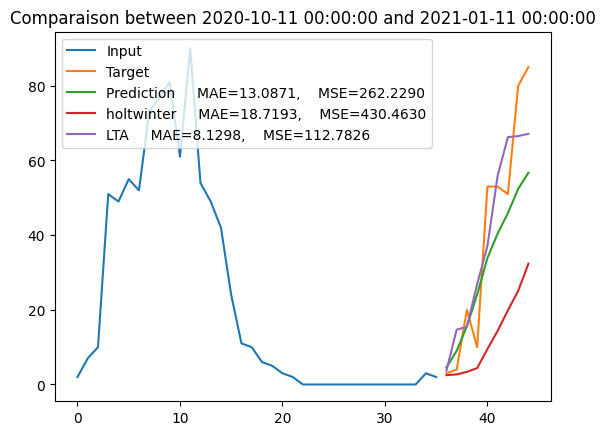

torch.Size([36, 2])
torch.Size([360, 2])


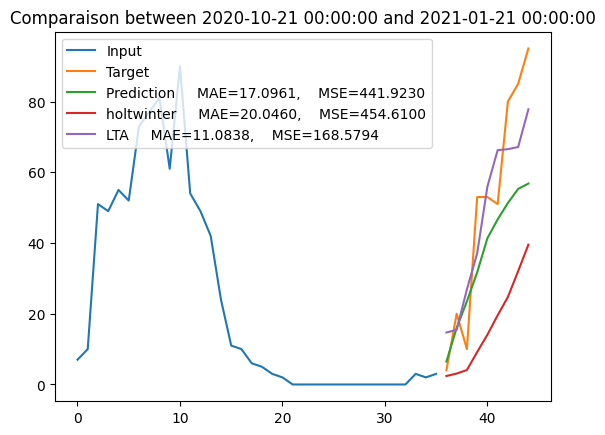

torch.Size([36, 2])
torch.Size([360, 2])


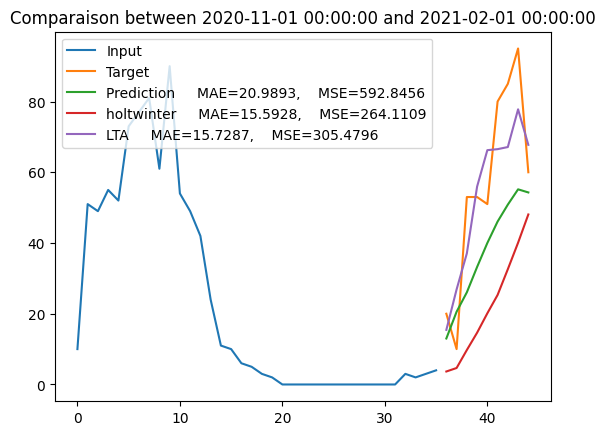

torch.Size([36, 2])
torch.Size([360, 2])


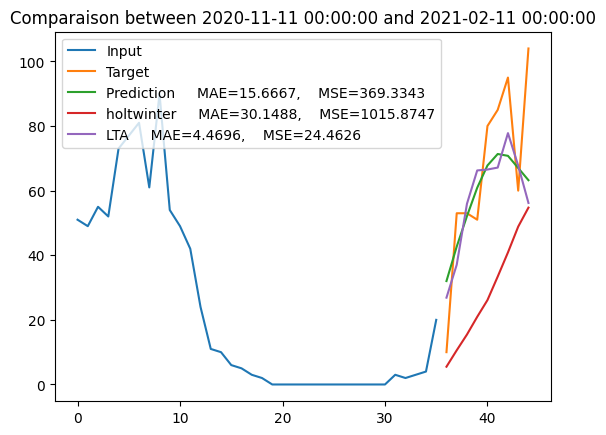

torch.Size([36, 2])
torch.Size([360, 2])


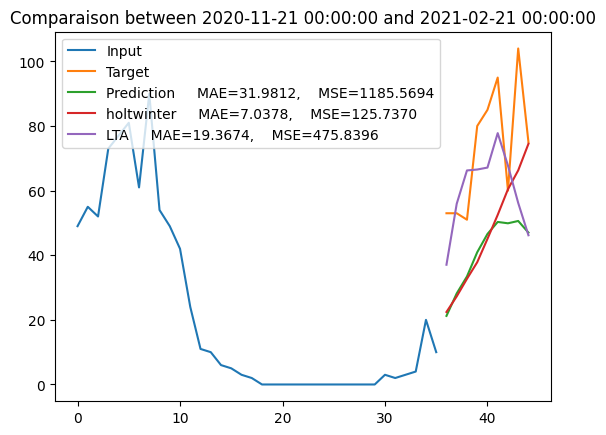

torch.Size([36, 2])
torch.Size([360, 2])


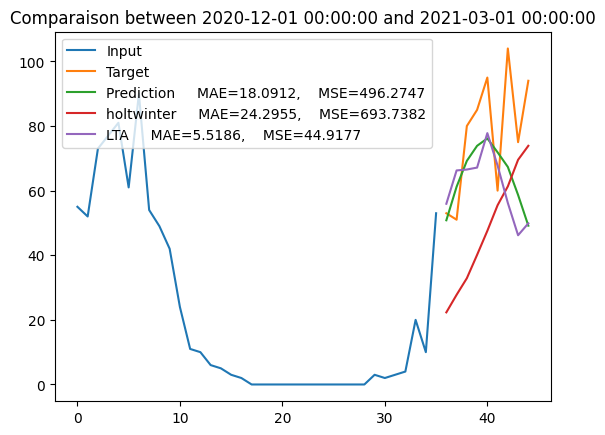

torch.Size([36, 2])
torch.Size([360, 2])


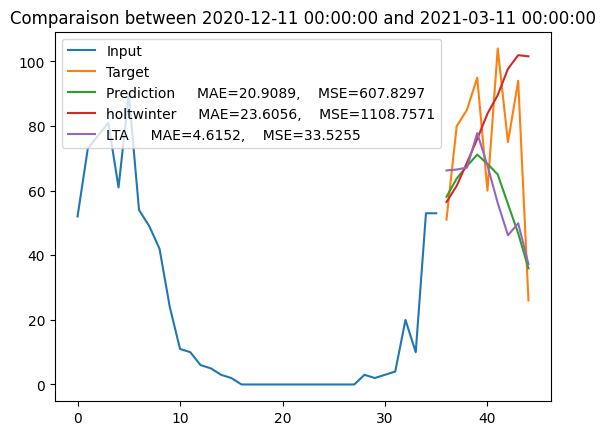

torch.Size([36, 2])
torch.Size([360, 2])


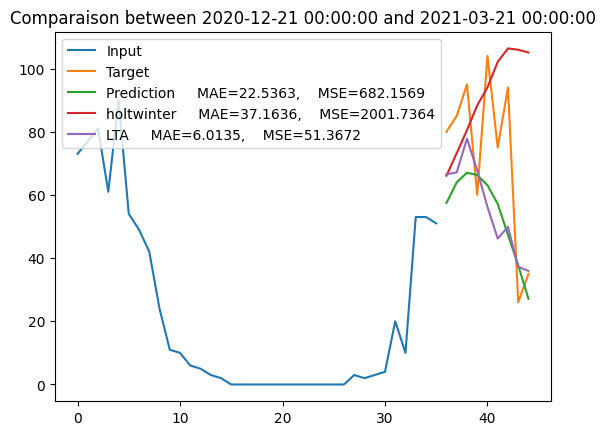

torch.Size([36, 2])
torch.Size([360, 2])


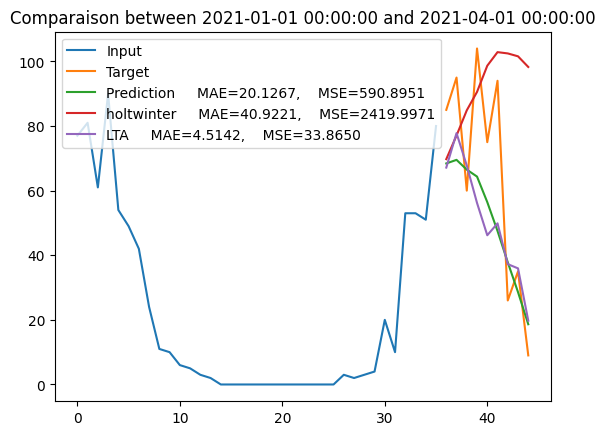

torch.Size([36, 2])
torch.Size([360, 2])


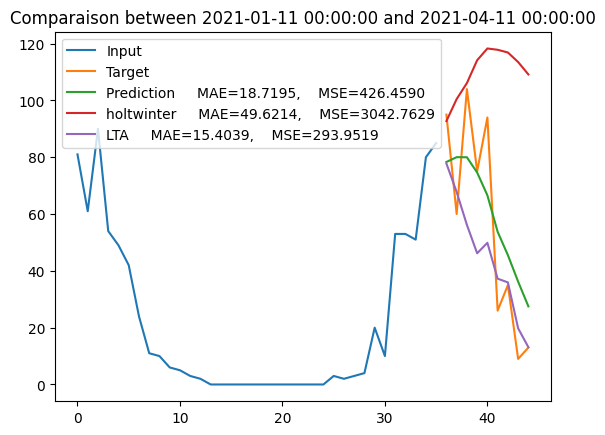

torch.Size([36, 2])
torch.Size([360, 2])


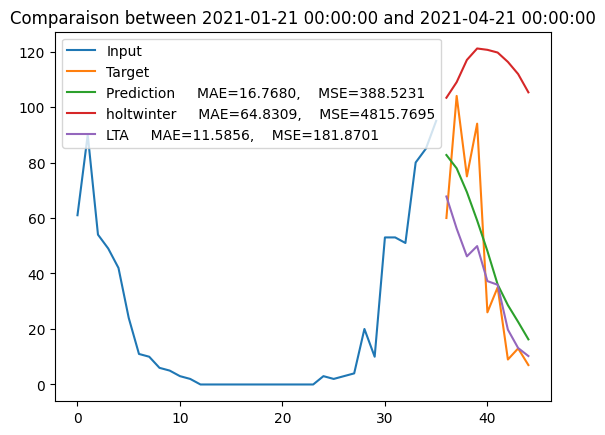

torch.Size([36, 2])
torch.Size([360, 2])


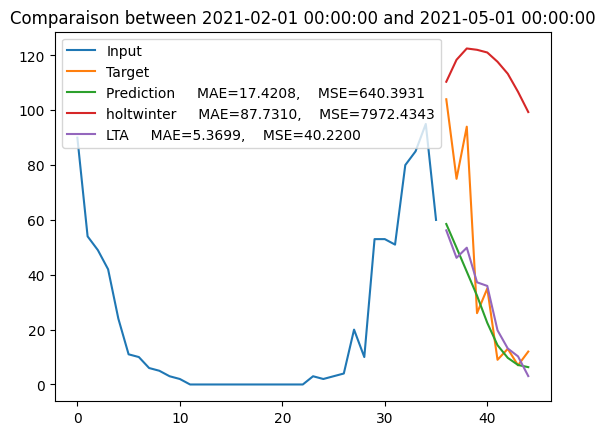

torch.Size([36, 2])
torch.Size([360, 2])


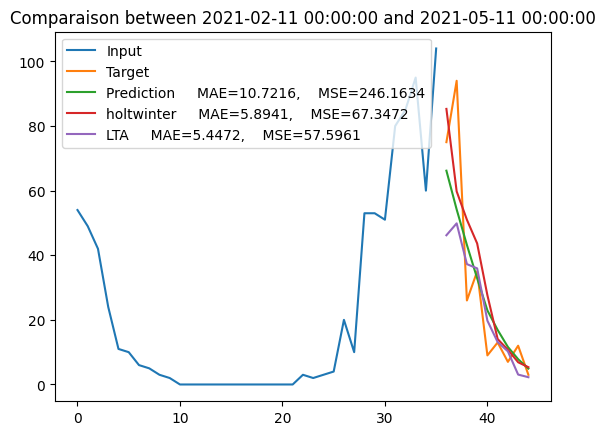

torch.Size([36, 2])
torch.Size([360, 2])


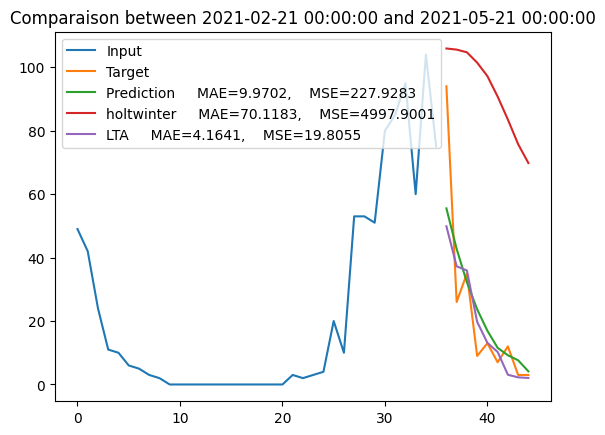

torch.Size([36, 2])
torch.Size([360, 2])


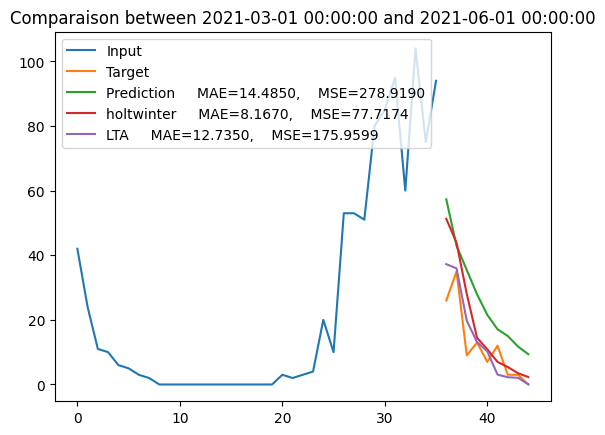

torch.Size([36, 2])
torch.Size([360, 2])


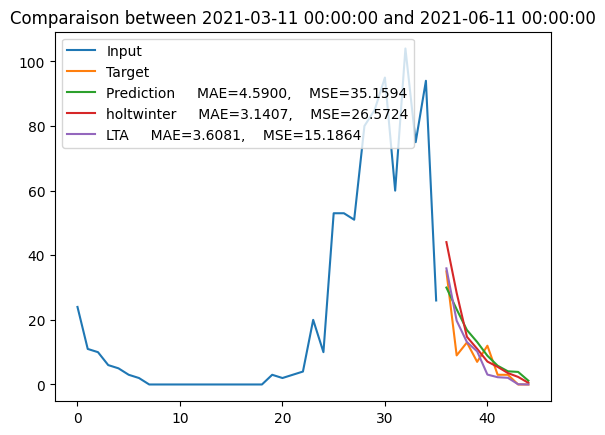

torch.Size([36, 2])
torch.Size([360, 2])


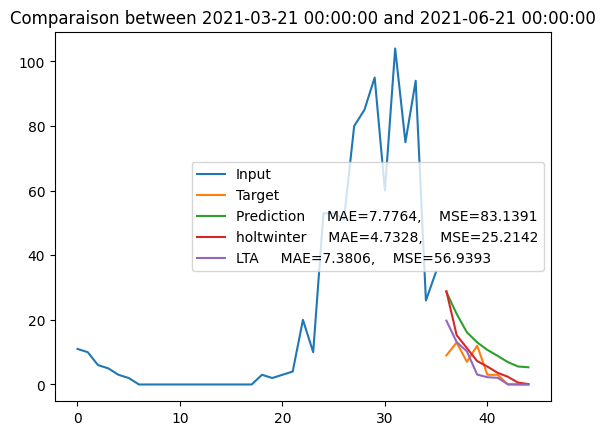

torch.Size([36, 2])
torch.Size([360, 2])


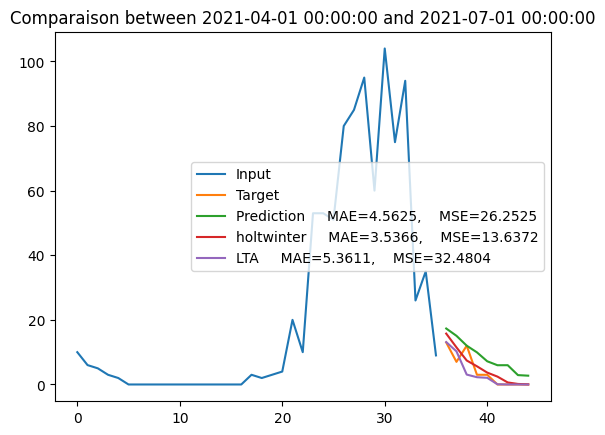

torch.Size([36, 2])
torch.Size([360, 2])


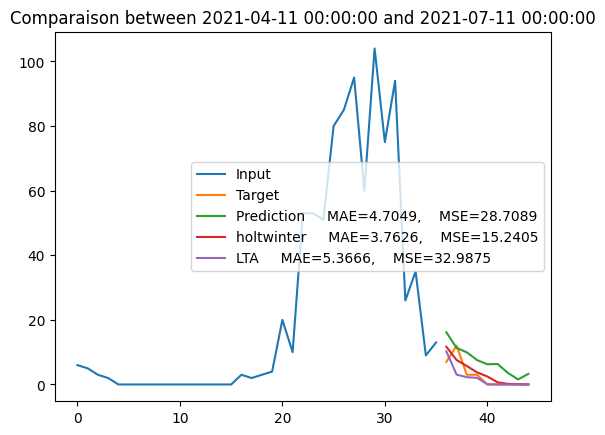

torch.Size([36, 2])
torch.Size([360, 2])


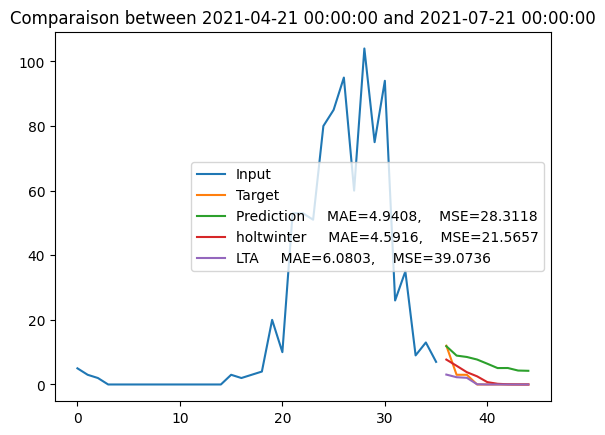

torch.Size([36, 2])
torch.Size([360, 2])


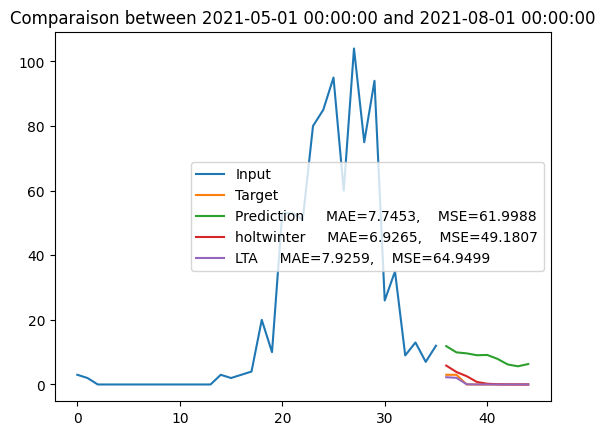

torch.Size([36, 2])
torch.Size([360, 2])


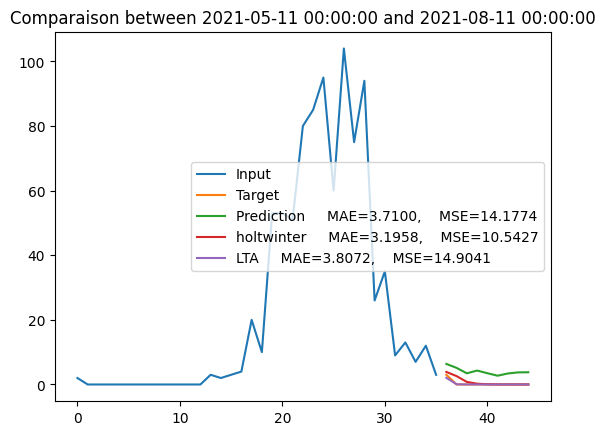

torch.Size([36, 2])
torch.Size([360, 2])


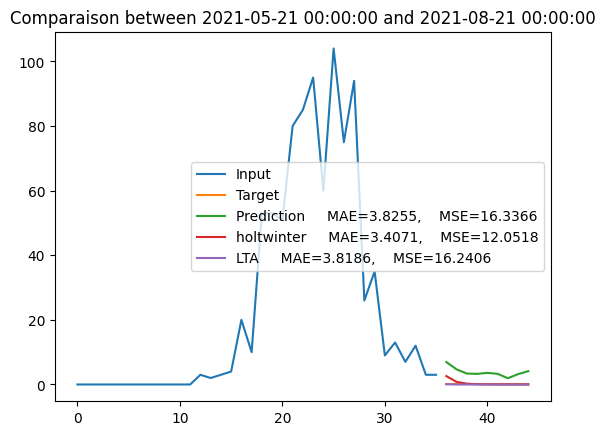

torch.Size([36, 2])
torch.Size([360, 2])


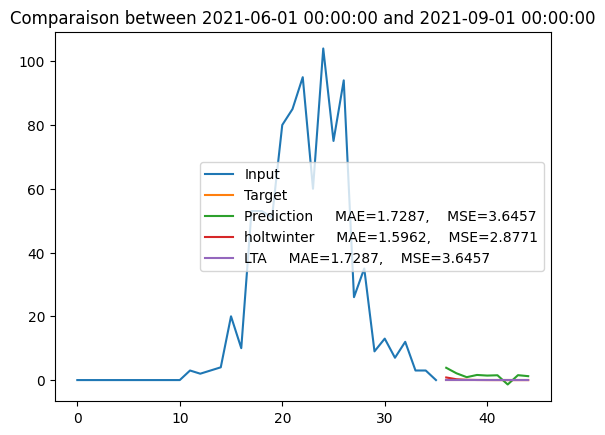

torch.Size([36, 2])
torch.Size([360, 2])


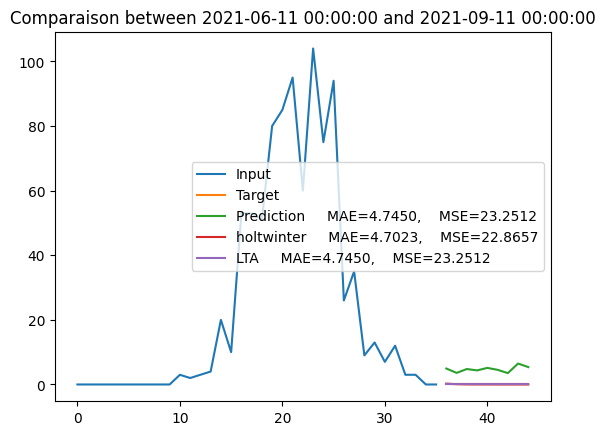

torch.Size([36, 2])
torch.Size([360, 2])


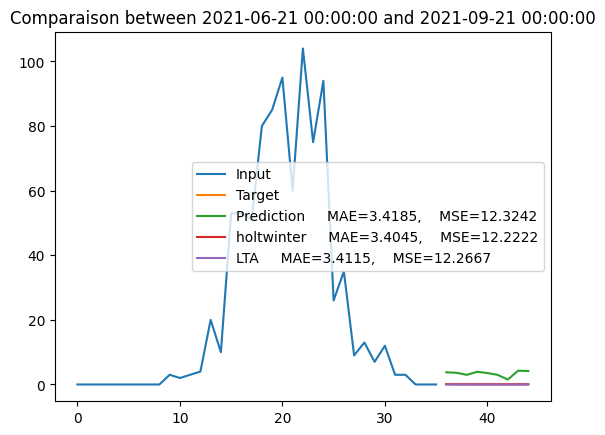

torch.Size([36, 2])
torch.Size([360, 2])


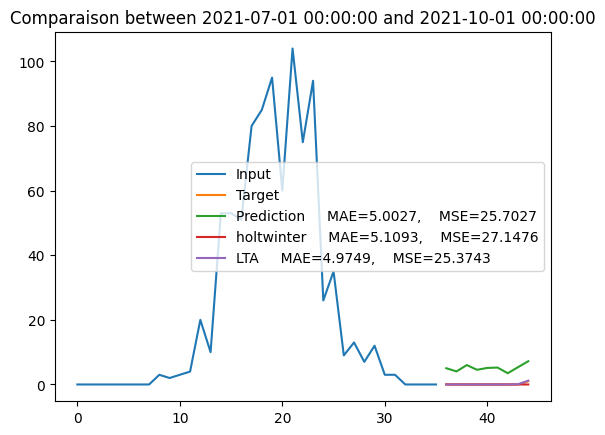

torch.Size([36, 2])
torch.Size([360, 2])


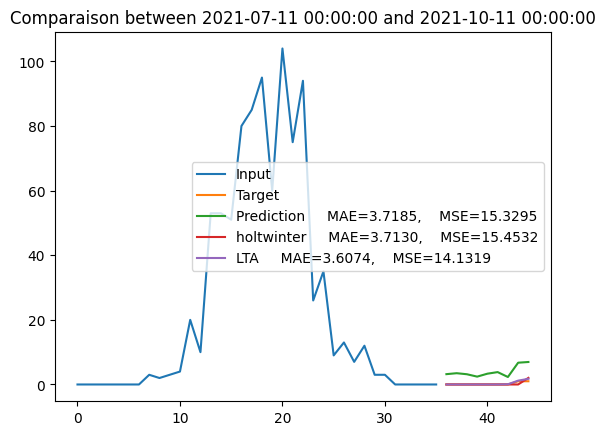

torch.Size([36, 2])
torch.Size([360, 2])


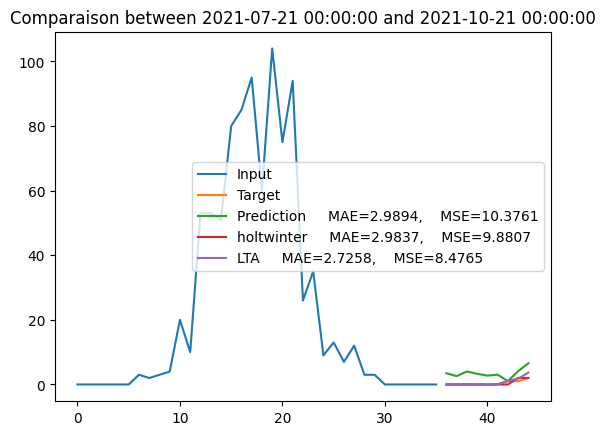

torch.Size([36, 2])
torch.Size([360, 2])


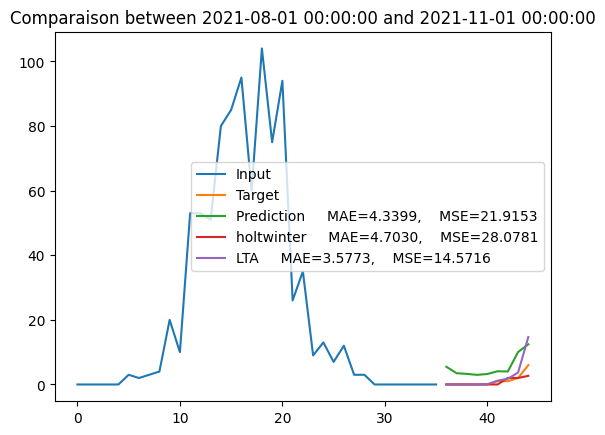

torch.Size([36, 2])
torch.Size([360, 2])


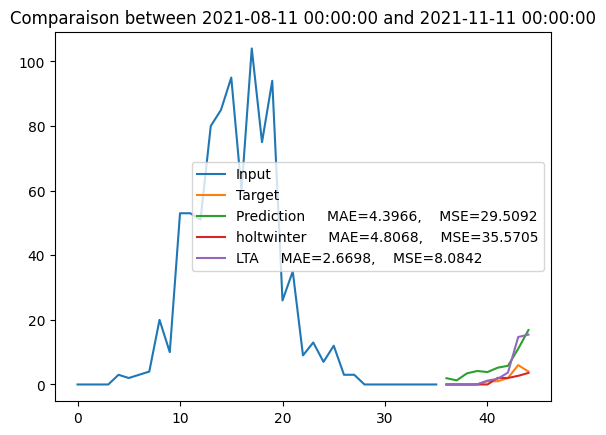

torch.Size([36, 2])
torch.Size([360, 2])


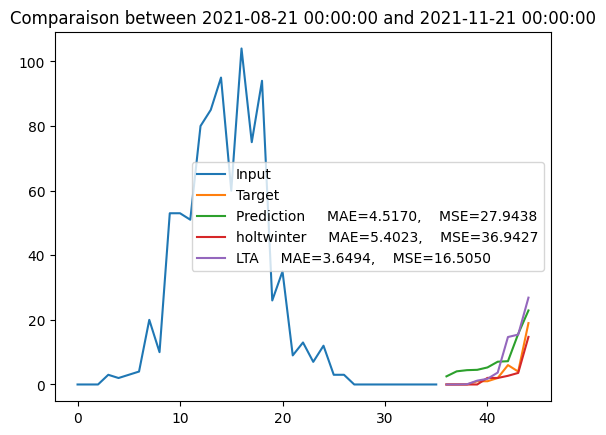

torch.Size([36, 2])
torch.Size([360, 2])


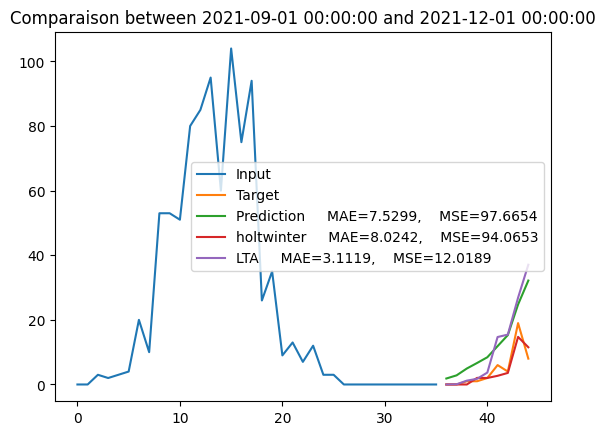

torch.Size([36, 2])
torch.Size([360, 2])


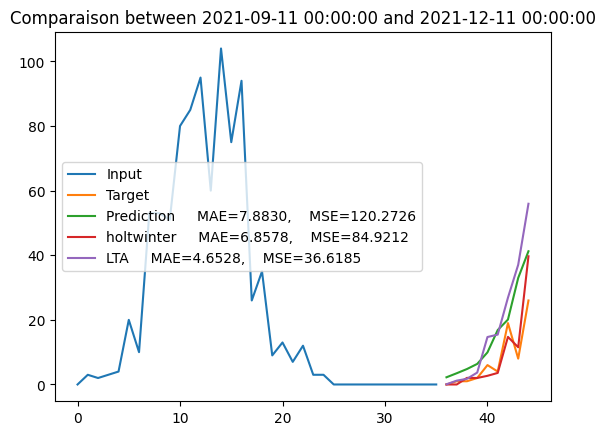

torch.Size([36, 2])
torch.Size([360, 2])


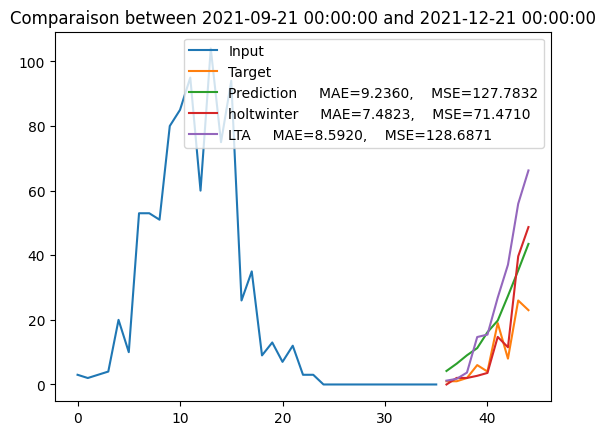

torch.Size([36, 2])
torch.Size([360, 2])


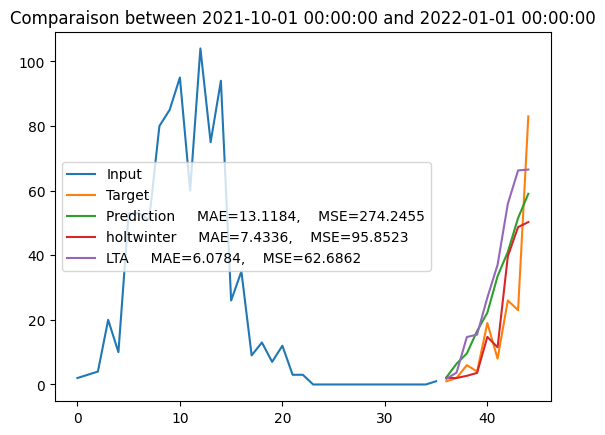

torch.Size([36, 2])
torch.Size([360, 2])


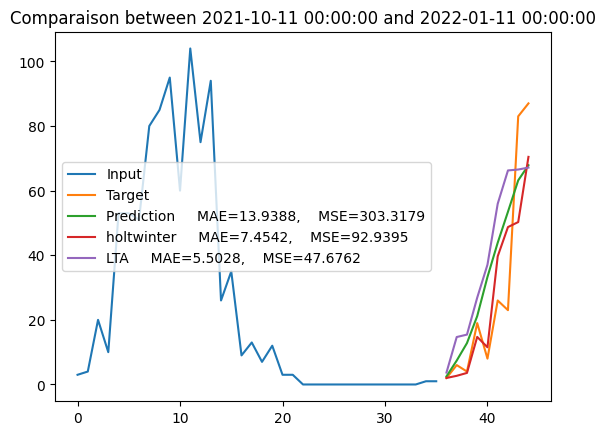

torch.Size([36, 2])
torch.Size([360, 2])


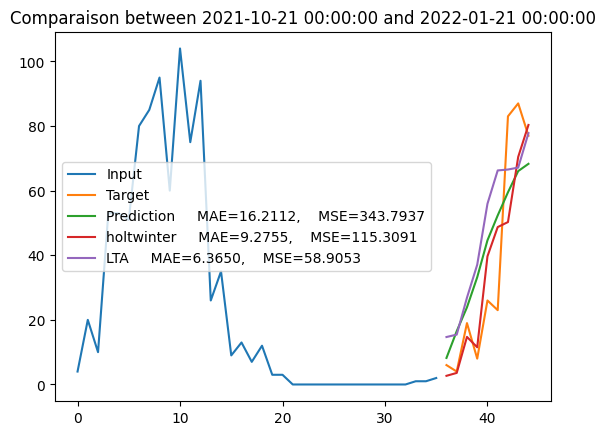

In [68]:
for index in range(10,50):
    inputs = dls.test.dataset[index][0]
    targets= dls.test.dataset[index][1]
    outputs = torch.Tensor(pred[index])

    # smoothed_patchtst = smooth(torch.Tensor(dls.test.dataset.inverse_transform(outputs)[:,1]*1e3))/1e3
    # lta = torch.tensor(get_LTA (lat,lon,index, config['sequence_length'], config['prediction_length']))  
    holtwinter = holtwinters_prediction(dls, index, variable=0)

    inputs_sample = inputs.cpu().detach().numpy()
    targets_sample = targets.cpu().detach().numpy()
    outputs_sample = outputs.cpu().detach().numpy()
    # lta_sample = lta.cpu().detach().numpy()
    s_begin = index
    s_end = s_begin + config_obj.sequence_length
    r_begin = s_end 
    r_end = r_begin + config_obj.prediction_length
    
    lta_sample=rfh_lta[r_begin-1:r_end-1]
    





    mae_patchtst = mean_absolute_error(dls.test.dataset.inverse_transform(targets)[:,0], dls.test.dataset.inverse_transform(outputs)[:,0])
    mse_patchtst = mean_squared_error(dls.test.dataset.inverse_transform(targets)[:,0], dls.test.dataset.inverse_transform(outputs)[:,0])

   

    mae_hw = mean_absolute_error(holtwinter, dls.test.dataset.inverse_transform(outputs)[:,0])
    mse_hw = mean_squared_error(holtwinter, dls.test.dataset.inverse_transform(outputs)[:,0])

    mae_lta = mean_absolute_error(lta_sample, dls.test.dataset.inverse_transform(outputs)[:,0])
    mse_lta = mean_squared_error(lta_sample, dls.test.dataset.inverse_transform(outputs)[:,0])




    time_input = np.arange(config["sequence_length"])
    time_future = np.arange(config["sequence_length"], config["sequence_length"] + config["prediction_length"])


    plt.plot(time_input, dls.test.dataset.inverse_transform(inputs_sample)[:, 0], label='Input')
    plt.plot(time_future, dls.test.dataset.inverse_transform(targets_sample)[:, 0], label='Target')
    plt.plot(time_future, dls.test.dataset.inverse_transform(outputs_sample)[:, 0], label=f'Prediction     MAE={mae_patchtst:.4f},    MSE={mse_patchtst:.4f}')
    # plt.plot(time_future, smoothed_patchtst, label=f'Smoothed_patchtst    MAE={mae_smoothed:.4f},    MSE={mse_smoothed:.4f}')
    plt.plot(time_future, holtwinter, label=f'holtwinter     MAE={mae_hw:.4f},    MSE={mse_hw:.4f}')
    plt.plot(time_future, lta_sample, label=f'LTA     MAE={mae_lta:.4f},    MSE={mse_lta:.4f}')

    plt.legend()
    plt.title(f"Comparaison between {time_column[r_begin-1]} and {time_column[r_end-1]}")

    plt.savefig("comparaison")
    plt.show()